# Steps to transform microbiome date

In [128]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import entropy
from sklearn.decomposition import PCA
from Bio.Blast import NCBIWWW, NCBIXML
from Bio import Entrez
import time 
from plotly.subplots import make_subplots
# Load microbiome data
microbiome_df = pd.read_csv("./data/microbiome.csv")
metadata_df = pd.read_csv("./data/metadata.csv")

# Display basic info
print("Microbiome Data:")
print(microbiome_df.info())
display(microbiome_df.head())

print("\nMetadata:")
print(metadata_df.info())
display(metadata_df.head())

Microbiome Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265 entries, 0 to 1264
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ASV      1265 non-null   object
 1   Kingdom  1265 non-null   object
 2   Phylum   1261 non-null   object
 3   Class    1261 non-null   object
 4   Order    1257 non-null   object
 5   Family   1132 non-null   object
 6   Genus    886 non-null    object
 7   PIG1     1265 non-null   int64 
 8   PIG2     1265 non-null   int64 
 9   PIG3     1265 non-null   int64 
 10  PIG4     1265 non-null   int64 
 11  PIG5     1265 non-null   int64 
 12  PIG6     1265 non-null   int64 
 13  PIG7     1265 non-null   int64 
 14  PIG8     1265 non-null   int64 
 15  PIG9     1265 non-null   int64 
 16  PIG10    1265 non-null   int64 
 17  PIG11    1265 non-null   int64 
 18  PIG12    1265 non-null   int64 
dtypes: int64(12), object(7)
memory usage: 187.9+ KB
None


,ASV,Kingdom,Phylum,Class,Order,Family,Genus,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
0,TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAG...,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,3115,1776,6541,1275,59,15464,18340,6,6114,3489,4433,8818
1,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia,428,1139,1111,1716,4035,1802,11677,102,4558,5514,2078,1623
2,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Subdoligranulum,841,2618,3717,2029,2581,899,3434,69,1856,4747,5660,1436
3,TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAG...,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,726,525,1472,7256,166,73,16184,540,1465,4,0,88
4,TACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAG...,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,0,45,18,0,0,6842,14584,0,330,398,1948,1733



Metadata:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Pig              12 non-null     int64 
 1   Treatment        12 non-null     object
 2   Day Euthanized   12 non-null     int64 
 3   Max Fecal Score  12 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 516.0+ bytes
None


,Pig,Treatment,Day Euthanized,Max Fecal Score
0,1,Sham,21,0
1,2,Sham,21,0
2,3,Sham,21,0
3,4,Sham,21,0
4,5,Bhyo,21,2


In [129]:
display(microbiome_df[abundance_columns].sum(axis=0))
display(simplified_microbiome_df[abundance_columns].sum(axis=0))

PIG1      73211
PIG2      60011
PIG3      80456
PIG4      62734
PIG5      71911
PIG6      59765
PIG7     150195
PIG8       1971
PIG9      72288
PIG10     52766
PIG11     72294
PIG12     60616
dtype: int64

NameError: name 'simplified_microbiome_df' is not defined

### Check for null values

In [130]:
#Looking for null vales
microbiome_df.isnull().sum()

#Now print the number of unique values in each column
print("Number of unique values in each column:")
for col in microbiome_df.columns:
    print(f"{col}: {microbiome_df[col].nunique()}")

#Now display the rows with missing values
print("\nRows with missing values:")
display(microbiome_df[microbiome_df.isnull().any(axis=1)])

Number of unique values in each column:
ASV: 1265
Kingdom: 3
Phylum: 19
Class: 27
Order: 38
Family: 57
Genus: 172
PIG1: 195
PIG2: 164
PIG3: 199
PIG4: 165
PIG5: 172
PIG6: 136
PIG7: 159
PIG8: 36
PIG9: 169
PIG10: 133
PIG11: 181
PIG12: 157

Rows with missing values:


,ASV,Kingdom,Phylum,Class,Order,Family,Genus,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
16,TACGTAGGGGGCGAGCGTTGTCCGGATTCATTGGGCGTAAAGCGCG...,Bacteria,Actinobacteria,Coriobacteriia,Coriobacteriales,Atopobiaceae,NaN,1246,605,975,816,1706,917,866,9,984,919,524,443
26,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,279,298,626,809,624,473,481,14,1188,733,203,262
43,TACGTAGGATGCAAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCT...,Bacteria,NaN,NaN,NaN,NaN,NaN,3567,0,36,0,0,0,0,0,0,0,0,0
44,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,0,0,0,161,0,0,0,0,954,52,32,2369
45,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,46,0,34,222,1437,448,68,0,638,17,190,175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,TACGTACGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTG...,Bacteria,Firmicutes,Clostridia,Clostridiales,NaN,NaN,0,0,2,0,0,0,0,0,0,0,0,0
1260,TACGTAGGCGGCGAGCGTTATCCGGAATGATTGGGCGTAAAGGGTG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,0,0,0,0,2,0,0,0,0,0,0,0
1261,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,Bacteria,Firmicutes,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae,NaN,0,0,0,0,0,2,0,0,0,0,0,0
1262,TACGTAGGTGGCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGTC...,Bacteria,Tenericutes,Mollicutes,Mollicutes_RF39,NaN,NaN,0,0,0,0,0,0,0,0,2,0,0,0


Ok so with the missing values I think there are some where the ASV is Specified but the phylum, class, order, family and genus are missing let's have a look for them.

In [131]:
# Display rows where any of the Kingdom, Phylum, Class, Order, Family, Genus, or Species columns are missing
print("\nRows with missing taxonomy:")
temp = missing_taxonomy_check = microbiome_df[
    microbiome_df[['Phylum', 'Class', 'Order', 'Family', 'Genus']].isnull().any(axis=1)
]
display(temp)
temp.to_csv("./data/outputs/microbiome/missing_taxonomy.csv", index=False)


Rows with missing taxonomy:


,ASV,Kingdom,Phylum,Class,Order,Family,Genus,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
16,TACGTAGGGGGCGAGCGTTGTCCGGATTCATTGGGCGTAAAGCGCG...,Bacteria,Actinobacteria,Coriobacteriia,Coriobacteriales,Atopobiaceae,NaN,1246,605,975,816,1706,917,866,9,984,919,524,443
26,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,279,298,626,809,624,473,481,14,1188,733,203,262
43,TACGTAGGATGCAAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCT...,Bacteria,NaN,NaN,NaN,NaN,NaN,3567,0,36,0,0,0,0,0,0,0,0,0
44,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,0,0,0,161,0,0,0,0,954,52,32,2369
45,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,46,0,34,222,1437,448,68,0,638,17,190,175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,TACGTACGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTG...,Bacteria,Firmicutes,Clostridia,Clostridiales,NaN,NaN,0,0,2,0,0,0,0,0,0,0,0,0
1260,TACGTAGGCGGCGAGCGTTATCCGGAATGATTGGGCGTAAAGGGTG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,0,0,0,0,2,0,0,0,0,0,0,0
1261,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,Bacteria,Firmicutes,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae,NaN,0,0,0,0,0,2,0,0,0,0,0,0
1262,TACGTAGGTGGCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGTC...,Bacteria,Tenericutes,Mollicutes,Mollicutes_RF39,NaN,NaN,0,0,0,0,0,0,0,0,2,0,0,0


#### Get missing taxonomies from BLAST

In [132]:
#Get a list of the asv ids that have missing taxonomy
missing_taxonomy_asv_ids = temp['ASV'].tolist()
for i in range(10):
    print(f"ASV ID: {missing_taxonomy_asv_ids[i]}")

ASV ID: TACGTAGGGGGCGAGCGTTGTCCGGATTCATTGGGCGTAAAGCGCGCGTAGGCGGCCCGGCAGGTCGGGGGTGAAAACACGGGGCCCAACCCCGTGCCTGCCCCCGAAACCGCCGGGCTCGAGTCCCGCAGGGGATGGCGGAACTCCCGGTGTAGCGGTGGAATGCGCAGATATCGGGAGGAACACCGGTGGCGAAGGCGGCCATCTGGGCGGGCACTGACGCTGAGGCGCGAGAGCCGGGGGAGCGAACAGG
ASV ID: TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAATGGCAAGTCTGATGTGAAAGGCCGGGGCTCAACCCCGGGACTGCATTGGAAACTGTCAATCTAGAGTACCGGAGGGGTAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAACAGG
ASV ID: TACGTAGGATGCAAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGCGGGAAGGTACGTTTGGAAGTAAATCTCACGGCTCAACTGTGAGCTCATTCCAAATACGGCTTTTCTTGAGGGCAGCAGGGGAGAATGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAAGAATACCGGTGGCGAAGGCGATTCTCTGGGCTGTGACTGACGCTGAGGAGCGAAAGCGTGGGTAGCGAACGGG
ASV ID: TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGATTAGCAAGTCAGATGTGAAAGGCGGGGGCTTAACCCCTGGATTGCATTTGAAACTGCGGATCTTGAGTACCGGAAGGGCAGATGGAATTCCTGGTGTAGCGGTGAAATGCGTAGAGATCAGGAGGAACACCGGTGGCGAAAGCGGTCTGC

In [133]:
Entrez.email = "marcus@metacell.us"  # <-- REPLACE with your email

# Function to query NCBI BLAST and retrieve taxonomy
def query_ncbi_blast(asv_sequence):
    try:
        result_handle = NCBIWWW.qblast("blastn", "nt", asv_sequence)
        blast_record = NCBIXML.read(result_handle)
        for alignment in blast_record.alignments[:1]:  # Get only top match
            for hsp in alignment.hsps:
                best_match_id = alignment.hit_id.split("|")[1]  # Extract NCBI ID
                return best_match_id  # Return best match ID
    except Exception as e:
        print(f"BLAST error for sequence: {asv_sequence[:30]}... - {e}")
        return None
    
# Function to get taxonomy from NCBI Taxonomy Database
# def get_taxonomy(ncbi_id):
#     try:
#         handle = Entrez.efetch(db="taxonomy", id=ncbi_id, retmode="xml")
#         records = Entrez.read(handle)
#         taxonomy = {rank["Rank"]: rank["ScientificName"] for rank in records[0]["LineageEx"]}
#         print(f"Taxonomy not found for NCBI ID {ncbi_id}")
#         #display handle information
#         print(f"hanlde information {handle}")
#         #display records information
#         print(f"records information {records}")            
#         return taxonomy
#     except Exception as e:
#         print(f"Taxonomy lookup error for NCBI ID {ncbi_id}: {e}")
#         return {}

def get_taxonomy(ncbi_id):
    if not ncbi_id:
        print("Error: NCBI ID is None, skipping taxonomy lookup.")
        return {"Kingdom": "Unknown", "Phylum": "Unknown", "Class": "Unknown", "Order": "Unknown", "Family": "Unknown", "Genus": "Unknown"}
    try:
        # Step 1: Fetch Nucleotide Entry to Get Organism Name
        handle = Entrez.efetch(db="nucleotide", id=ncbi_id, rettype="gb", retmode="xml")
        records = Entrez.read(handle)
        if not records:
            print(f"Warning: No nucleotide data found for NCBI ID {ncbi_id}")
            return {"Kingdom": "Unknown", "Phylum": "Unknown", "Class": "Unknown", "Order": "Unknown", "Family": "Unknown", "Genus": "Unknown"}
        
        # Extract Organism Name
        organism_name = records[0].get("GBSeq_organism", "Unknown")
        print(f"Organism for {ncbi_id}: {organism_name}")
        
        # Step 2: Fetch Correct Taxonomy ID from Organism Name
        search_handle = Entrez.esearch(db="taxonomy", term=organism_name, retmode="xml")
        search_results = Entrez.read(search_handle)
        taxonomy_id = search_results["IdList"][0] if search_results["IdList"] else None
        if not taxonomy_id:
            print(f"Warning: No taxonomy ID found for organism {organism_name}")
            return {"Kingdom": "Unknown", "Phylum": "Unknown", "Class": "Unknown", "Order": "Unknown", "Family": "Unknown", "Genus": "Unknown"}
        
        # Step 3: Fetch Taxonomy Data Using Correct Taxonomy ID
        tax_handle = Entrez.efetch(db="taxonomy", id=taxonomy_id, retmode="xml")
        tax_records = Entrez.read(tax_handle)
        taxonomy = {rank["Rank"]: rank["ScientificName"] for rank in tax_records[0].get("LineageEx", [])}
        return {
            "Kingdom": taxonomy.get("superkingdom", "Unknown"),
            "Phylum": taxonomy.get("phylum", "Unknown"),
            "Class": taxonomy.get("class", "Unknown"),
            "Order": taxonomy.get("order", "Unknown"),
            "Family": taxonomy.get("family", "Unknown"),
            "Genus": taxonomy.get("genus", "Unknown")
        }
    except Exception as e:
        print(f"Taxonomy lookup error for NCBI ID {ncbi_id}: {e}")
        return {"Kingdom": "Unknown", "Phylum": "Unknown", "Class": "Unknown", "Order": "Unknown", "Family": "Unknown", "Genus": "Unknown"}

In [47]:
blast_results = {}
for asv in missing_taxonomy_asv_ids:
    ncbi_id = query_ncbi_blast(asv)
    taxonomy = get_taxonomy(ncbi_id)
    blast_results[asv] = taxonomy
    time.sleep(1)  # Sleep for 1 second to avoid NCBI rate limits

#Store blast results
blast_df = pd.DataFrame(blast_results)
blast_df.head()

Organism for 192981498: uncultured bacterium
Organism for 482670902: uncultured bacterium
Organism for 169290422: uncultured bacterium
Organism for 1046551313: uncultured bacterium
Organism for 322117191: uncultured bacterium
Organism for 291330516: uncultured Bacteroidota bacterium
Organism for 2318643617: Anaerobutyricum hallii
Organism for 765566380: uncultured Eubacterium sp.
Organism for 388933607: uncultured bacterium
Organism for 223688948: uncultured bacterium
Organism for 18644574: uncultured bacterium
Organism for 765561004: uncultured Blautia sp.
Organism for 388935932: uncultured bacterium
Organism for 2189981405: uncultured Prevotellaceae bacterium
Organism for 270061400: uncultured bacterium
Organism for 698323519: uncultured bacterium
Organism for 388930070: uncultured bacterium
Organism for 2103567833: Mediterraneibacter sp.
Organism for 765567573: uncultured Lachnospiraceae bacterium
Organism for 663093801: uncultured bacterium
Organism for 1046551529: uncultured bacte

/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WXDET5RV016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 846494326: uncultured bacterium
Organism for 238068049: uncultured bacterium
Organism for 2305803371: uncultured bacterium


/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WXE71YRE016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 2065397894: uncultured bacterium
Organism for 239620638: uncultured Bacillota bacterium


/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WXF862EM016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 2209976369: uncultured Mollicutes bacterium
Organism for 258687216: uncultured bacterium
Organism for 219533827: uncultured bacterium
Organism for 388930632: uncultured bacterium
Organism for 324959938: uncultured bacterium
Organism for 388929181: uncultured bacterium
Organism for 169277724: uncultured bacterium
Organism for 388935903: uncultured bacterium


/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WXGMJHKG013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 110440476: uncultured bacterium
Organism for 1046551623: uncultured bacterium
Organism for 388930882: uncultured bacterium
Organism for 310841962: uncultured bacterium
Organism for 765566121: uncultured Roseburia sp.
Organism for 388929983: uncultured bacterium
Organism for 60327316: uncultured bacterium
Organism for 576096421: uncultured bacterium
Organism for 1110839593: uncultured bacterium
Organism for 1523161745: Blautia sp.
Organism for 1046551686: uncultured bacterium


/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WXJ2U5F0016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 846491418: uncultured bacterium
Organism for 765565246: uncultured Barnesiella sp.
Organism for 388933155: uncultured bacterium
Organism for 1110839240: uncultured bacterium
Organism for 1060741347: uncultured bacterium
Organism for 1280076018: uncultured bacterium
Organism for 363546169: uncultured bacterium
Organism for 2215065150: uncultured bacterium
Organism for 765561111: uncultured bacterium
Organism for 218083166: uncultured bacterium
Organism for 169290644: uncultured bacterium
Organism for 192980374: uncultured bacterium
Organism for 1227153093: uncultured bacterium
Organism for 388931193: uncultured bacterium
Organism for 1060740818: uncultured bacterium
Organism for 169285182: uncultured bacterium
Organism for 18644227: uncultured bacterium
Organism for 765564751: uncultured Barnesiella sp.
Organism for 388929559: uncultured bacterium
Organism for 198209848: uncultured bacterium
Organism for 258548704: uncultured bacterium
Organism for 1110839105: uncultured ba

/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WXMF6XGE016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 765564411: uncultured Prevotella sp.
Organism for 1060741749: uncultured bacterium
Organism for 765562008: uncultured Lachnospiraceae bacterium
Organism for 167962964: uncultured bacterium
Organism for 2189981017: uncultured Coriobacteriaceae bacterium
Organism for 18644470: uncultured bacterium
Organism for 1060741389: uncultured bacterium


/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WXRHAFK3013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 18644472: uncultured bacterium
Organism for 2209976173: uncultured Mollicutes bacterium
Organism for 169290383: uncultured bacterium
Organism for 2209976468: uncultured Eubacteriales bacterium
Organism for 765561377: uncultured Coriobacteriaceae bacterium
Organism for 214020493: uncultured bacterium
Organism for 1046552399: uncultured bacterium
Organism for 258548239: uncultured bacterium


/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WXSXPJAV013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 1568621647: uncultured bacterium
Organism for 2305803842: uncultured bacterium
Organism for 2209975882: uncultured Prevotellaceae bacterium


/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WXUANGUW013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 324960131: uncultured bacterium


/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WXUY3Y5A013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 319488080: uncultured organism
Organism for 392976364: uncultured bacterium


/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WXVRNXC2013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 2209975610: uncultured Erysipelotrichaceae bacterium
Organism for 388929711: uncultured bacterium
Organism for 310841559: uncultured bacterium
Organism for 2581468667: uncultured bacterium
Organism for 363545604: uncultured bacterium
Organism for 576097541: uncultured bacterium


/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WXX0Z84Z013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 2209976177: uncultured Mollicutes bacterium
Organism for 2794113440: Mediterraneibacter hominis
Organism for 2189980993: uncultured Eubacteriales bacterium
Organism for 258686738: uncultured bacterium
Organism for 151358358: uncultured Erysipelotrichaceae bacterium
Organism for 765565898: uncultured Anaerostipes sp.
Organism for 169277758: uncultured bacterium
Organism for 1060742008: uncultured bacterium
Organism for 18644473: uncultured bacterium
Organism for 2318612424: Anaerobutyricum hallii
Organism for 218081416: uncultured bacterium
Organism for 166202987: uncultured rumen bacterium
Organism for 1532253437: uncultured bacterium
Organism for 342219199: uncultured bacterium
Organism for 576097602: uncultured bacterium
Organism for 2258084935: Eubacterium ventriosum
Organism for 18644238: uncultured bacterium
Organism for 1110839382: uncultured bacterium
Organism for 2872330665: bacterium
Organism for 169282805: uncultured bacterium
Organism for 1046551558: uncultured 

/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WY0CE4MH013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 388929098: uncultured bacterium
Organism for 166202802: uncultured rumen bacterium
Organism for 270061132: uncultured bacterium
Organism for 223689272: uncultured bacterium
Organism for 2209976403: uncultured Mollicutes bacterium
Organism for 765566077: uncultured bacterium
Organism for 576097541: uncultured bacterium
Organism for 2189981442: uncultured bacterium
Organism for 1284882486: uncultured Oscillospiraceae bacterium
Organism for 1610101821: uncultured Bacteroidia bacterium
Organism for 1110839100: uncultured bacterium
Organism for 1110839306: uncultured bacterium
Organism for 1046551773: uncultured bacterium
Organism for 2209976966: uncultured Muribaculaceae bacterium
Organism for 110436315: uncultured bacterium
Organism for 765564751: uncultured Barnesiella sp.
Organism for 1046552534: uncultured bacterium
Organism for 388930125: uncultured bacterium
Organism for 110443957: uncultured bacterium
Organism for 223688759: uncultured bacterium
Organism for 2710185567:

/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WYA8VU6D013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 1060741249: uncultured bacterium
Organism for 765565905: uncultured bacterium
Organism for 18644363: uncultured bacterium
Organism for 1046551731: uncultured bacterium
Organism for 1743543444: uncultured bacterium
Organism for 315229148: uncultured bacterium
Organism for 319657153: uncultured bacterium
Organism for 324959801: uncultured bacterium
Organism for 765563590: uncultured Lachnospiraceae bacterium
Organism for 59329233: uncultured archaeon
Organism for 324960011: uncultured bacterium
Organism for 1060741831: uncultured bacterium
Organism for 1046552122: uncultured bacterium
Organism for 192975808: uncultured bacterium
Organism for 2054242328: Eubacterium sp. MSJ-33
Organism for 2209976695: uncultured Muribaculaceae bacterium
Organism for 110441388: uncultured bacterium
Organism for 388935598: uncultured bacterium
Organism for 1284876323: uncultured Clostridiales Family XIV bacterium
Organism for 388929099: uncultured bacterium
Organism for 388932944: uncultured ba

/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WYEAR3E1013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Error: NCBI ID is None, skipping taxonomy lookup.
Organism for 1046552246: uncultured bacterium
Organism for 1046552399: uncultured bacterium
Organism for 170673905: uncultured bacterium
Organism for 2209976387: uncultured Lachnoclostridium sp.
Organism for 1046552455: uncultured bacterium
Organism for 765568157: uncultured Selenomonas sp.
Organism for 1046552275: uncultured bacterium
Organism for 1284876323: uncultured Clostridiales Family XIV bacterium
Organism for 765566110: uncultured bacterium
Organism for 1046551819: uncultured bacterium
Organism for 169277816: uncultured bacterium
Organism for 1046551859: uncultured bacterium
Organism for 2209976296: Candidatus Melainabacteria bacterium
Organism for 1315215242: uncultured Lachnospiraceae bacterium
Organism for 169279218: uncultured bacterium
Organism for 169290703: uncultured bacterium
Organism for 18644653: uncultured bacterium


/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WYH3SHFK016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 765567427: uncultured Clostridium sp.


/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WYHWHMFD016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 1046552356: uncultured bacterium
Organism for 1774711862: uncultured Porphyromonadaceae bacterium
Organism for 363546169: uncultured bacterium
Organism for 2305796807: uncultured bacterium
Organism for 1046552673: uncultured bacterium
Organism for 2305803428: uncultured bacterium
Organism for 1046551883: uncultured bacterium
Organism for 2215065166: uncultured Oscillospiraceae bacterium
Organism for 1046551879: uncultured bacterium
Organism for 2215065166: uncultured Oscillospiraceae bacterium
Organism for 576097617: uncultured bacterium
Organism for 1046552584: uncultured bacterium
Organism for 765565599: uncultured Acidaminobacter sp.
Organism for 1046552271: uncultured bacterium
Organism for 765565289: uncultured Parabacteroides sp.
Organism for 765567558: uncultured bacterium
Organism for 765563716: uncultured Prevotella sp.
Organism for 388935950: uncultured bacterium
Organism for 1774712540: uncultured Clostridium sp.
Organism for 223689018: uncultured bacterium
Orga

/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WYNFX6E5013 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


BLAST error for sequence: TACGTAGGGAGCGAGCGTTGTCCGGATTTA... - HTTP Error 404: Not Found
Error: NCBI ID is None, skipping taxonomy lookup.
BLAST error for sequence: TACGTAGGTGGCAAGCGTTATCCGGATTTA... - HTTP Error 404: Not Found
Error: NCBI ID is None, skipping taxonomy lookup.
BLAST error for sequence: TACGTAGGGGGCAAGCGTTATCCGGATTTA... - HTTP Error 404: Not Found
Error: NCBI ID is None, skipping taxonomy lookup.
BLAST error for sequence: TACGTAGGGAGCAAGCGTTGTCCGGAATTA... - HTTP Error 404: Not Found
Error: NCBI ID is None, skipping taxonomy lookup.
BLAST error for sequence: TACGTAGGTGGCAAGCGTTGTCCGGAATTA... - HTTP Error 404: Not Found
Error: NCBI ID is None, skipping taxonomy lookup.
BLAST error for sequence: TACGTAGGGAGCGAGCGTTGTCCGGATTTA... - HTTP Error 404: Not Found
Error: NCBI ID is None, skipping taxonomy lookup.
Organism for 388935918: uncultured bacterium
Organism for 1110839546: uncultured bacterium
Organism for 1270530721: uncultured bacterium
Organism for 253764216: uncultured 

/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WYR42F9N016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 1743543239: uncultured bacterium
Organism for 1046552673: uncultured bacterium
Organism for 2209976298: uncultured Oscillospiraceae bacterium
Organism for 480327870: uncultured archaeon
Organism for 253764081: uncultured bacterium
Organism for 261261528: uncultured bacterium
Organism for 1110839251: uncultured bacterium
Organism for 1227155119: uncultured bacterium
Organism for 1046552003: uncultured bacterium
Organism for 1046552284: uncultured bacterium
Organism for 169282772: uncultured bacterium
Organism for 1060742363: uncultured bacterium
Organism for 2209976918: uncultured Eubacteriales bacterium
Organism for 1110839474: uncultured bacterium
Organism for 765567272: uncultured Roseburia sp.
Organism for 18644384: uncultured bacterium
Organism for 765561283: uncultured Anaerovorax sp.
Organism for 2209976517: uncultured Eubacteriales bacterium
Organism for 2209977213: uncultured Rhodospirillales bacterium
Organism for 2581468219: uncultured bacterium
Organism for 1046

/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WYX0W8ZU016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 258686704: uncultured bacterium
Organism for 1110839364: uncultured bacterium
Organism for 192975418: uncultured bacterium
Organism for 1046552239: uncultured bacterium
Organism for 1110839426: uncultured bacterium
Organism for 2215065166: uncultured Oscillospiraceae bacterium
Organism for 388929683: uncultured bacterium
Organism for 1060741109: uncultured bacterium
Organism for 698324533: uncultured bacterium
Organism for 2318611604: Eubacterium coprostanoligenes
Organism for 943840257: uncultured prokaryote
Organism for 2581468185: uncultured bacterium
Organism for 313758935: uncultured bacterium
Organism for 2581655224: uncultured Oscillospiraceae bacterium
Organism for 765565692: uncultured Parabacteroides sp.
Organism for 110441357: uncultured bacterium
Organism for 319517443: uncultured organism
Organism for 1046552246: uncultured bacterium
Organism for 2189981479: uncultured Anaerofilum sp.
Organism for 1060741051: uncultured bacterium


/opt/anaconda3/envs/cobo_lab/lib/python3.12/site-packages/Bio/Blast/NCBIWWW.py:275: BiopythonWarning: BLAST request WZ0797E1016 is taking longer than 10 minutes, consider re-issuing it
  warnings.warn(


Organism for 41814027: uncultured bacterium
Organism for 2318637813: Flintibacter butyricus
Organism for 319487898: uncultured organism
Organism for 291328074: uncultured Pseudomonadota bacterium
Organism for 310843269: uncultured bacterium
Organism for 1060741700: uncultured bacterium
Organism for 363547219: uncultured bacterium
Organism for 258548356: uncultured bacterium
Organism for 310838789: uncultured bacterium
Organism for 169290440: uncultured bacterium
Organism for 765567061: uncultured Insolitispirillum sp.
Organism for 765568355: uncultured Oscillospiraceae bacterium
Organism for 258683452: uncultured bacterium
Organism for 2318615082: Succinivibrio dextrinosolvens
Organism for 169132982: uncultured bacterium
Organism for 110440617: uncultured bacterium
Organism for 765563690: uncultured Prevotella sp.
Organism for 1201262591: uncultured bacterium
Organism for 169278647: uncultured bacterium
Organism for 1060742357: uncultured bacterium
Organism for 324959956: uncultured ba

,TACGTAGGGGGCGAGCGTTGTCCGGATTCATTGGGCGTAAAGCGCGCGTAGGCGGCCCGGCAGGTCGGGGGTGAAAACACGGGGCCCAACCCCGTGCCTGCCCCCGAAACCGCCGGGCTCGAGTCCCGCAGGGGATGGCGGAACTCCCGGTGTAGCGGTGGAATGCGCAGATATCGGGAGGAACACCGGTGGCGAAGGCGGCCATCTGGGCGGGCACTGACGCTGAGGCGCGAGAGCCGGGGGAGCGAACAGG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAATGGCAAGTCTGATGTGAAAGGCCGGGGCTCAACCCCGGGACTGCATTGGAAACTGTCAATCTAGAGTACCGGAGGGGTAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAACAGG,TACGTAGGATGCAAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGCGGGAAGGTACGTTTGGAAGTAAATCTCACGGCTCAACTGTGAGCTCATTCCAAATACGGCTTTTCTTGAGGGCAGCAGGGGAGAATGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAAGAATACCGGTGGCGAAGGCGATTCTCTGGGCTGTGACTGACGCTGAGGAGCGAAAGCGTGGGTAGCGAACGGG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGATTAGCAAGTCAGATGTGAAAGGCGGGGGCTTAACCCCTGGATTGCATTTGAAACTGCGGATCTTGAGTACCGGAAGGGCAGATGGAATTCCTGGTGTAGCGGTGAAATGCGTAGAGATCAGGAGGAACACCGGTGGCGAAAGCGGTCTGCTGGACGGTAACTGACGTTGAGGCTCGAAGGCGTGGGGAGCAAACAGG,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGCAGTGCAAGTCAGATGTGAAAGGCCGGGGCTCAACCCCGGAGCTGCATTTGAAACTGCATAGCTAGAGTACAGGAGAGGCAGGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCCTGCTGGACTGTTACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACAGG,TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGTCTTTTAAGCGTGTTGTGAAATACTGTCGCTCAACGACAGAGGTGCAGCGCGAACTGGGAGACTTGAGTGCGCGGAATGCAGGCGGAATTCGTCGTGTAGCGGTGAAATGCTTAGATATGACGAAGAACTCCGATTGCGAAGGCAGCTTGCAGTAGCGTAACTGACGCTGAAGCTCGAAAGTGCGGGTATCGAACAGG,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGCAGTGCAAGTCAGATGTGAAAGGCCGGGGCTCAACCCCGGAGCTGCATTTGAAACTGCTCGGCTAGAGTACAGGAGAGGCAGGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCCTGCTGGACTGTTACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACAGG,CACGTAGGGGGCGAGCGTTATCCGGAATTACTGGGCGTAAAGAGTGCGTAGGTGGCTTTTTAAGCGCGGGGTCTAAGGCTATGGCCTAACCATAGTCCGCCCTGCGAACTGGAGAGCTTGAGTACAGGAGGGGAAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTTCTGGACTGAAACTGACACTGAGGCACGAAAGCGTGGGTAGCAAACAGG,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGCGCGCCAAGTCAGCGGTCAAAGTTCCGGGCTCAACCCGGTGTCGCCGTTGAAACTGGCGTGCTCGAGTGCGTGCGAGGAAGGCGGAATGCGTTGTGTAGCGGTGAAATGCATAGATATGACGCAGAACTCCGATTGCGAAGGCAGCTTTCCAGCGCGCTACTGACGCTGAGGCACGAAAGCGTGGGGATCGAACAGG,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGCGCGTCAAGCCGGTGGTAAAATTGCGGGGCTCAACCCCGTAGAGCCATCGGAACTGGCGTGCTTGAGTGGAGAAGAAGTATGCGGAATGCGAGGTGTAGCGGTGAAATGCATAGATATCGCGCAGAACTCCGATTGCGAAGGCAGCGTACTATTCTCCAACTGACGCTGAGGCACGAAAGCGTGGGGATCGAACAGG,...,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTAATGCAAGTCTGAAGTGAAATGCGGGGGCTCAACCCCTGAACTGCTTTGGAAACTGTATAACTGGAGTGCAGGAGAGGTAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATCGCGCAGAACTCCGATTGCGAAGGCAGCGTACTATTCTCCAACTGACGCTGAGGCACGAAAGCGTGGGTAGCGAACAGG,AACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGTGGGACAGCAAGTTCAATGTGAAATCTATGGGCTCAACCCATAAATTGCGTTGGATACTGCAGTTCTTGAGTGGAGTAGAGGCAGGCGGAATTCCAGGTGTAGCGGTGGAATGCGTAGATATCTGGAGGAACACCAGTGGCGAAGGCGGCCTGCTGGGCTCTAACTGACACTGAGGCTCGAAAGCGTGGGTAGCAAACAGG,TACATAGGGAGCAAGCGTTGTCCGGAATTACTGGGCGTAAAGGGAACGTAGGCGGTTCTGCAAGTCAGAGGTGAAATCCCGGGGCTTAACTCCGGAATTGCCTTTGAAACTGCAGGACTAGAGTGTGGGAGAGGAAGATGGAATTCCAAGTGTAGCGGTGGAATGCGTAGATATTTGGAAGAACATCAGAGGCGAAGGCGATCTTCTGGAACACAACTGACGCTTAGGTTCGAAAGCGTGGGGAGCAAACAGG,TACGGAGGGTGCGAGCGTTAATCGGAATAACTGGGCGTAAAGGGCACGCAGGCGGTGACTTAAGTGAGGTGTGAAAGCCCCGGGCTTAACCTGGGAATTGCATTTCATACTGGGTCGCTAGAGTACTTTAGGGAGGGGTAGAATTCCACGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTGCTGGACAAATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCGAACAGG,TACGTAGGTGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGCGCGTAGGCGGGGATGCAAGTCAGATGTGAAATCTATGGGCTTAACCCATAAACTGCATTTGAAACTATATCTCTTGAGTGCTGGAGAGGTAGATGGAATTCCTTGTGTAGCGGTGAAATGCGTAGATATCACGCAGAACTCCGATTGCGAAGGCAGCATGCCAGCCGCCGACTGACGCTGAGGCACGAAAGTGCGGGTATCGAACAGG,TACGTACGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGCAGTGCAAGTCAGATGTGAAAGGCCGGGGCTCAACTCCGGAGCTGCATTTGAAACTGCTCGGCTAGAGTACAGGAGAGGCAGGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATCACGAAGAACTCCG

In [50]:
blast_df.to_csv("./data/outputs/microbiome/blast_results.csv", index=False)

#### Load in the missing blast_df

In [134]:
blast_df = pd.read_csv("./data/outputs/microbiome/blast_results.csv")
blast_df = blast_df.transpose()

# Now rename the columns
blast_df.columns = ["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]
blast_df.index.name = "ASV"
blast_df.reset_index(inplace=True)

# Display the blast results
print("Blast Results:")
print(blast_df.info())
display(blast_df.head())


Blast Results:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ASV      379 non-null    object
 1   Kingdom  379 non-null    object
 2   Phylum   379 non-null    object
 3   Class    379 non-null    object
 4   Order    379 non-null    object
 5   Family   379 non-null    object
 6   Genus    379 non-null    object
dtypes: object(7)
memory usage: 20.9+ KB
None


,ASV,Kingdom,Phylum,Class,Order,Family,Genus
0,TACGTAGGGGGCGAGCGTTGTCCGGATTCATTGGGCGTAAAGCGCG...,Bacteria,Unknown,Unknown,Unknown,Unknown,Unknown
1,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,Bacteria,Unknown,Unknown,Unknown,Unknown,Unknown
2,TACGTAGGATGCAAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCT...,Bacteria,Unknown,Unknown,Unknown,Unknown,Unknown
3,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,Bacteria,Unknown,Unknown,Unknown,Unknown,Unknown
4,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTG...,Bacteria,Unknown,Unknown,Unknown,Unknown,Unknown


##### QC Check 1: Are there mismatches in the ASV IDs?

In [135]:
# Compare the ASVs in microbiome_df, missing_taxonomy_df and blast_df
microbiome_df_set = set(microbiome_df['ASV'])
missing_taxonomy_df_set = set(temp['ASV'])
blast_df_set = set(blast_df['ASV'])

microbiome_df_missing_taxonomy = microbiome_df_set.difference(missing_taxonomy_df_set)
missing_taxonomy_df_missing_blast = missing_taxonomy_df_set.difference(blast_df_set)
microbiome_df_missing_blast = microbiome_df_set.difference(blast_df_set)

print(f"# ASVs in microbiome_df but not in missing_taxonomy_df: {len(microbiome_df_missing_taxonomy)}")
print(f"# ASVs in missing_taxonomy_df but not in blast_df: {len(missing_taxonomy_df_missing_blast)}")
print(f"# ASVs in microbiome_df but not in blast_df: {len(microbiome_df_missing_blast)}")

# Are all the blast and missing taxonomy ASVs in the microbiome data?
print("Are all the blast and missing taxonomy ASVs in the microbiome data?")
print(f"# ASVs in missing_taxonomy_df but not in microbiome_df: {len(missing_taxonomy_df_set.difference(microbiome_df_set))}")
print(f"# ASVs in blast_df but not in microbiome_df: {len(blast_df_set.difference(microbiome_df_set))}")


# ASVs in microbiome_df but not in missing_taxonomy_df: 886
# ASVs in missing_taxonomy_df but not in blast_df: 0
# ASVs in microbiome_df but not in blast_df: 886
Are all the blast and missing taxonomy ASVs in the microbiome data?
# ASVs in missing_taxonomy_df but not in microbiome_df: 0
# ASVs in blast_df but not in microbiome_df: 0


##### QC Check 2: Verifying the NCBI taxonomy completeness
Are there unknown values in the blast_df? Or are there meaningful insights?

In [136]:
# How many values are still unknown?
print("Number of unknown values in each taxonomy column:")
for col in blast_df.columns:
    print(f"{col}: {sum(blast_df[col] == 'Unknown')} out of {len(blast_df)}")

#How many rows have all unknown values?
print("\nNumber of rows with all unknown taxonomy:")
print(sum(blast_df[['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']].apply(lambda x: all(x == 'Unknown'), axis=1)))

# How many with only the kingdom?
print("\nNumber of rows with only Kingdom known:")
print(sum(blast_df[['Phylum', 'Class', 'Order', 'Family', 'Genus']].apply(lambda x: all(x == 'Unknown'), axis=1)))

# How many with only the kingdom and phylum?
print("\nNumber of rows with only Kingdom and Phylum known:")
print(sum(blast_df[['Class', 'Order', 'Family', 'Genus']].apply(lambda x: all(x == 'Unknown'), axis=1)))

# How many with only the kingdom, phylum, and class?
print("\nNumber of rows with only Kingdom, Phylum, and Class known:")
print(sum(blast_df[['Order', 'Family', 'Genus']].apply(lambda x: all(x == 'Unknown'), axis=1)))

# How many with only the kingdom, phylum, class, and order?
print("\nNumber of rows with only Kingdom, Phylum, Class, and Order known:")
print(sum(blast_df[['Family', 'Genus']].apply(lambda x: all(x == 'Unknown'), axis=1)))

# How many with only the kingdom, phylum, class, order, and family?
print("\nNumber of rows with only Kingdom, Phylum, Class, Order, and Family known:")
print(sum(blast_df['Genus'] == 'Unknown'))

# How many entries have all taxonomy information?
print("\nNumber of rows with all taxonomy known:")
print(sum(blast_df[['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']].apply(lambda x: all(x != 'Unknown'), axis=1)))

Number of unknown values in each taxonomy column:
ASV: 0 out of 379
Kingdom: 222 out of 379
Phylum: 279 out of 379
Class: 285 out of 379
Order: 293 out of 379
Family: 300 out of 379
Genus: 328 out of 379

Number of rows with all unknown taxonomy:
163

Number of rows with only Kingdom known:
279

Number of rows with only Kingdom and Phylum known:
285

Number of rows with only Kingdom, Phylum, and Class known:
293

Number of rows with only Kingdom, Phylum, Class, and Order known:
299

Number of rows with only Kingdom, Phylum, Class, Order, and Family known:
328

Number of rows with all taxonomy known:
21


#### Fill in the known blast_df data into microbiome_df

In [137]:
microbiome_df

,ASV,Kingdom,Phylum,Class,Order,Family,Genus,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
0,TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAG...,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,3115,1776,6541,1275,59,15464,18340,6,6114,3489,4433,8818
1,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia,428,1139,1111,1716,4035,1802,11677,102,4558,5514,2078,1623
2,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Subdoligranulum,841,2618,3717,2029,2581,899,3434,69,1856,4747,5660,1436
3,TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAG...,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,726,525,1472,7256,166,73,16184,540,1465,4,0,88
4,TACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAG...,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,0,45,18,0,0,6842,14584,0,330,398,1948,1733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,TACGTAGGCGGCGAGCGTTATCCGGAATGATTGGGCGTAAAGGGTG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,0,0,0,0,2,0,0,0,0,0,0,0
1261,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,Bacteria,Firmicutes,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae,NaN,0,0,0,0,0,2,0,0,0,0,0,0
1262,TACGTAGGTGGCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGTC...,Bacteria,Tenericutes,Mollicutes,Mollicutes_RF39,NaN,NaN,0,0,0,0,0,0,0,0,2,0,0,0
1263,TACGTAGGGAGCAAGCGTTGTCCGGAATGACTGGGCGTAAAGGGCG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Christensenellaceae,NaN,0,0,0,0,0,0,0,0,2,0,0,0


In [138]:
conflict_counter = 0
updated_counter = 0
# Fill in the missing taxonomy values with the blast results
for i in range(len(missing_taxonomy_asv_ids)):
    asv = missing_taxonomy_asv_ids[i]
    #Get the blast taxonomy
    blast_taxonomy = blast_df[blast_df["ASV"] == asv].iloc[0, 1:].to_dict()
    # print(f"ASV: {asv} - Taxonomy: {blast_taxonomy}")

    # Get the microbiome_df taxonomy
    microbiome_taxonomy = microbiome_df[microbiome_df["ASV"] == asv][["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]].iloc[0].to_dict()
    # print(f"ASV: {asv} - Microbiome Taxonomy: {microbiome_taxonomy}")

    # Use the blast taxonomy to fill in missing values if it contains more information
    for key, value in blast_taxonomy.items():
        # Only update if the value is not "Unknown"
        if value != "Unknown":
            # Now check if there is a value in the microbiome taxonomy
            if microbiome_taxonomy[key] == "Unknown":
                # Update the microbiome taxonomy
                updated_counter += 1
                microbiome_taxonomy[key] = value
            # If the microbiome taxonomy has a value, but it is different from the blast taxonomy
            elif microbiome_taxonomy[key] != value:
                print(f"ASV: {asv} - Conflict in {key}: {microbiome_taxonomy[key]} vs {value}, retaining original value.")
                conflict_counter += 1
    # print(f"ASV: {asv} - Updated Microbiome Taxonomy: {microbiome_taxonomy}")

    # Update the microbiome_df with the new taxonomy values
    for key, value in microbiome_taxonomy.items():
        microbiome_df.loc[microbiome_df["ASV"] == asv, key] = value

# Now get the updated missing values in the microbiome_df
missing_taxonomy_check = microbiome_df[
    microbiome_df[['Phylum', 'Class', 'Order', 'Family', 'Genus']].isnull().any(axis=1)
]
print("Number of updated values:", updated_counter)
print("Number of conflicts:", conflict_counter)
print("Updated Missing Taxonomy:")
display(missing_taxonomy_check)

ASV: TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGTCTTTTAAGCGTGTTGTGAAATACTGTCGCTCAACGACAGAGGTGCAGCGCGAACTGGGAGACTTGAGTGCGCGGAATGCAGGCGGAATTCGTCGTGTAGCGGTGAAATGCTTAGATATGACGAAGAACTCCGATTGCGAAGGCAGCTTGCAGTAGCGTAACTGACGCTGAAGCTCGAAAGTGCGGGTATCGAACAGG - Conflict in Phylum: Bacteroidetes vs Bacteroidota, retaining original value.
ASV: TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGCAGTGCAAGTCAGATGTGAAAGGCCGGGGCTCAACCCCGGAGCTGCATTTGAAACTGCTCGGCTAGAGTACAGGAGAGGCAGGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCCTGCTGGACTGTTACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACAGG - Conflict in Phylum: Firmicutes vs Bacillota, retaining original value.
ASV: TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGCAGTGCAAGTCAGATGTGAAAGGCCGGGGCTCAACCCCGGAGCTGCATTTGAAACTGCTCGGCTAGAGTACAGGAGAGGCAGGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCCTGCTGGACTGTTACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACAGG - Conflict in Order: Clostridiales vs Lachnospirales, retaining origina

,ASV,Kingdom,Phylum,Class,Order,Family,Genus,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
16,TACGTAGGGGGCGAGCGTTGTCCGGATTCATTGGGCGTAAAGCGCG...,Bacteria,Actinobacteria,Coriobacteriia,Coriobacteriales,Atopobiaceae,NaN,1246,605,975,816,1706,917,866,9,984,919,524,443
26,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,279,298,626,809,624,473,481,14,1188,733,203,262
43,TACGTAGGATGCAAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCT...,Bacteria,NaN,NaN,NaN,NaN,NaN,3567,0,36,0,0,0,0,0,0,0,0,0
44,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,0,0,0,161,0,0,0,0,954,52,32,2369
45,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,46,0,34,222,1437,448,68,0,638,17,190,175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,TACGTACGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTG...,Bacteria,Firmicutes,Clostridia,Clostridiales,NaN,NaN,0,0,2,0,0,0,0,0,0,0,0,0
1260,TACGTAGGCGGCGAGCGTTATCCGGAATGATTGGGCGTAAAGGGTG...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,0,0,0,0,2,0,0,0,0,0,0,0
1261,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,Bacteria,Firmicutes,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae,NaN,0,0,0,0,0,2,0,0,0,0,0,0
1262,TACGTAGGTGGCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGTC...,Bacteria,Tenericutes,Mollicutes,Mollicutes_RF39,NaN,NaN,0,0,0,0,0,0,0,0,2,0,0,0


Oh nothing changed, Was this a waste?

##### Checking conflict patterns?

In [139]:
from collections import Counter
conflict_types = []

for i in range(len(missing_taxonomy_asv_ids)):
    asv = missing_taxonomy_asv_ids[i]
    blast_taxonomy = blast_df[blast_df["ASV"] == asv].iloc[0, 1:].to_dict()
    microbiome_taxonomy = microbiome_df[microbiome_df["ASV"] == asv][["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]].iloc[0].to_dict()
    
    for key in blast_taxonomy.keys():
        if blast_taxonomy[key] != "Unknown" and microbiome_taxonomy[key] != "Unknown" and blast_taxonomy[key] != microbiome_taxonomy[key]:
            conflict_types.append(key)

print(Counter(conflict_types))  # See which levels are conflicting most


Counter({'Phylum': 100, 'Order': 63, 'Genus': 51, 'Family': 51, 'Class': 6})


In [140]:
# Reviewing first 20 conflict patterns
conflicting_entries = []

for i in range(len(missing_taxonomy_asv_ids)):
    asv = missing_taxonomy_asv_ids[i]
    blast_taxonomy = blast_df[blast_df["ASV"] == asv].iloc[0, 1:].to_dict()
    microbiome_taxonomy = microbiome_df[microbiome_df["ASV"] == asv][["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]].iloc[0].to_dict()
    
    for key in blast_taxonomy.keys():
        if blast_taxonomy[key] != "Unknown" and microbiome_taxonomy[key] != "Unknown" and blast_taxonomy[key] != microbiome_taxonomy[key]:
            conflicting_entries.append((asv, key, microbiome_taxonomy[key], blast_taxonomy[key]))

# Display first few conflicts
conflicting_entries_df = pd.DataFrame(conflicting_entries, columns=["ASV", "Level", "Microbiome Taxonomy", "BLAST Taxonomy"])
display(conflicting_entries_df.head(20))
print(f"Total number of conflicts: {len(conflicting_entries)}")



,ASV,Level,Microbiome Taxonomy,BLAST Taxonomy
0,TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Phylum,Bacteroidetes,Bacteroidota
1,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTG...,Phylum,Firmicutes,Bacillota
2,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTG...,Order,Clostridiales,Lachnospirales
3,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTG...,Genus,NaN,Anaerobutyricum
4,CACGTAGGGGGCGAGCGTTATCCGGAATTACTGGGCGTAAAGAGTG...,Phylum,Firmicutes,Bacillota
5,CACGTAGGGGGCGAGCGTTATCCGGAATTACTGGGCGTAAAGAGTG...,Order,Clostridiales,Eubacteriales
6,CACGTAGGGGGCGAGCGTTATCCGGAATTACTGGGCGTAAAGAGTG...,Family,Family_XIII,Eubacteriaceae
7,CACGTAGGGGGCGAGCGTTATCCGGAATTACTGGGCGTAAAGAGTG...,Genus,NaN,Eubacterium
8,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,Phylum,Firmicutes,Bacillota
9,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,Order,Clostridiales,Lachnospirales


Total number of conflicts: 271


For now I will just save this as a csv and hand it to the Cobo lab to double check

In [141]:
conflicting_entries_df.to_csv("./data/outputs/microbiome/conflicting_entries.csv", index=False)

### Merge rows if all classes are the same.
NB If all Phylum, Class, Order, Family, Genus are missing leave unmerged.

When merging, take the mean ignoring nans.

In [142]:
# Create a simplified microbiome_df by grouping by taxonomy. Note we are averaging the relative abundance values across the taxonomies, but leaving the NaN values as is.
# Get unique taxonomy values of the microbiome_df
abundance_columns = list(microbiome_df.columns[7:])
# print(f"Abundance Columns: {abundance_columns}")
unique_taxonomy = microbiome_df[['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']].drop_duplicates()
unique_taxonomy = unique_taxonomy.sort_values(by=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus'])
# print("Unique Taxonomy:")
# print(unique_taxonomy.info())
# display(unique_taxonomy.tail())

# Loop through each unique taxonomu and get the average relative abundance values. Place into a new dataframe.
simplified_microbiome_df = pd.DataFrame(columns=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus'] + abundance_columns)

for i in range(len(unique_taxonomy)):
    tax = unique_taxonomy.iloc[i]
    # if the tax is all nan, skip
    if tax.isnull().all():
        continue
    else:
        tax_df = microbiome_df[
            (microbiome_df['Kingdom'] == tax['Kingdom']) &
            (microbiome_df['Phylum'] == tax['Phylum']) &
            (microbiome_df['Class'] == tax['Class']) &
            (microbiome_df['Order'] == tax['Order']) &
            (microbiome_df['Family'] == tax['Family']) &
            (microbiome_df['Genus'] == tax['Genus'])
        ]
        # Average the relative abundance values for each PIG
        mean_values = tax_df[abundance_columns].mean(skipna=True)
        # Concatenate if all mean values are not nan
        new_data = list(tax) + list(mean_values)
        new_entry = pd.DataFrame([new_data], columns=simplified_microbiome_df.columns)
        
        #Now append the new entry to the simplified_microbiome_df
        simplified_microbiome_df = pd.concat([simplified_microbiome_df, new_entry], ignore_index=True)

simplified_microbiome_df


/var/folders/6f/d2f9mt417y32sjcfd4zvfwdh0000gn/T/ipykernel_96942/1374271447.py:35: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,Kingdom,Phylum,Class,Order,Family,Genus,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,1612.5,0.0,382.0,210.0,0.000000,0.0,60.000000,0.0,7.500000,12.5,4.5,18.0
1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanosphaera,0.0,36.5,731.5,655.0,800.500000,1274.5,2587.500000,7.5,678.500000,339.5,87.0,889.0
2,Archaea,Euryarchaeota,Thermoplasmata,Methanomassiliicoccales,Methanomethylophilaceae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,0.0,0.0,2.5,0.0,0.000000,0.0,12.000000,0.0,11.000000,0.0,0.0,1.5
4,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Aeriscardovia,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,10.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,Bacteria,Tenericutes,Mollicutes,Izimaplasmatales,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201,Bacteria,Tenericutes,Mollicutes,Mollicutes_RF39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,0.0,0.0,0.0,0.0,0.666667,0.0,2.333333,0.0,1.333333,396.0,0.0,0.0
203,Bacteria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
#Now save the simplified microbiome_df
simplified_microbiome_df.to_csv("./data/outputs/microbiome/simplified_microbiome.csv", index=False)

##### Check if the taxonomies were truly merged

In [144]:
print("Before merging:", microbiome_df.shape[0])
print("After merging:", simplified_microbiome_df.shape[0])


Before merging: 1265
After merging: 205


##### Describe the counts to see if they make sense

In [145]:
#Describe the values for each column of simplified_microbiomoe_df
display(simplified_microbiome_df.describe())
#Describe the values for each row of simplified_microbiomoe_df
temp = simplified_microbiome_df.transpose().iloc[6:]
display(temp)


,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.00000,172.000000,172.000000,172.000000,172.000000
mean,55.289189,45.351874,59.893473,48.175347,86.517529,39.776766,110.568252,1.34148,55.921726,44.203592,51.982727,53.656306
std,192.492977,188.663852,121.819879,108.315912,333.164702,134.591409,359.429408,4.64487,147.269386,140.759317,126.050334,137.502413
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,4.900000,3.583333,7.733333,5.000000,3.125000,0.535714,3.583333,0.00000,2.000000,0.000000,4.857143,1.750000
75%,26.571429,28.187500,58.750000,30.711538,26.410714,12.375000,19.000000,0.00000,37.200000,10.562500,38.000000,26.400000
max,1612.500000,2316.500000,789.000000,655.000000,3016.000000,1274.500000,2587.500000,27.50000,1138.666667,1370.000000,1133.000000,889.000000


,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
PIG1,1612.5,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,547.333333,0.0,NaN,NaN,0.0,NaN,0.0
PIG2,0.0,36.5,NaN,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,14.333333,4.0,NaN,NaN,0.0,NaN,0.0
PIG3,382.0,731.5,NaN,2.5,0.0,1.2,0.0,0.0,0.0,0.0,...,4.0,NaN,NaN,76.666667,0.0,NaN,NaN,0.0,NaN,0.0
PIG4,210.0,655.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,13.833333,0.0,NaN,NaN,0.0,NaN,0.0
PIG5,0.0,800.5,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,1.166667,0.0,NaN,NaN,0.666667,NaN,0.0
PIG6,0.0,1274.5,NaN,0.0,0.0,2.6,0.0,9.0,13.0,0.0,...,0.0,NaN,NaN,0.5,0.0,NaN,NaN,0.0,NaN,5.0
PIG7,60.0,2587.5,NaN,12.0,0.0,797.8,6.0,25.0,33.0,7.0,...,0.0,NaN,NaN,6.0,0.0,NaN,NaN,2.333333,NaN,0.0
PIG8,0.0,7.5,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0
PIG9,7.5,678.5,NaN,11.0,0.0,115.2,0.0,0.0,0.0,2.0,...,12.0,NaN,NaN,1.666667,0.0,NaN,NaN,1.333333,NaN,0.0
PIG10,12.5,339.5,NaN,0.0,0.0,516.2,0.0,3.0,0.0,0.0,...,0.0,NaN,NaN,4.666667,0.0,NaN,NaN,396.0,NaN,0.0


In [146]:
# Drop rows with all NaN values
simplified_microbiome_df = simplified_microbiome_df.dropna(how='all', subset=abundance_columns)
# Save as csv
simplified_microbiome_df.to_csv("./data/outputs/microbiome/simplified_microbiome.csv", index=False)

## Preprocessing

### Ensure key columns only contain numeric values and all samples have some samples

In [147]:
# Check for zero sum samples
zero_sum_samples = simplified_microbiome_df[simplified_microbiome_df[abundance_columns].sum(axis=1) == 0]
print("Zero sum samples:")
display(zero_sum_samples)

# Display basic stats
simplified_microbiome_df[abundance_columns].describe()

Zero sum samples:


,Kingdom,Phylum,Class,Order,Family,Genus,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12


,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.00000,172.000000,172.000000,172.000000,172.000000
mean,55.289189,45.351874,59.893473,48.175347,86.517529,39.776766,110.568252,1.34148,55.921726,44.203592,51.982727,53.656306
std,192.492977,188.663852,121.819879,108.315912,333.164702,134.591409,359.429408,4.64487,147.269386,140.759317,126.050334,137.502413
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,4.900000,3.583333,7.733333,5.000000,3.125000,0.535714,3.583333,0.00000,2.000000,0.000000,4.857143,1.750000
75%,26.571429,28.187500,58.750000,30.711538,26.410714,12.375000,19.000000,0.00000,37.200000,10.562500,38.000000,26.400000
max,1612.500000,2316.500000,789.000000,655.000000,3016.000000,1274.500000,2587.500000,27.50000,1138.666667,1370.000000,1133.000000,889.000000


Good. 
1. No zero sum samples exist. (i.e. all probes here have a value)
2. The basic stats show that all samples have a some bacteria in them

However it is worth pointing out I'm down to 172 bacteria now.

Also I noticed that `PIG8` has sufficiently lower abundance counts here. Let's explore this further. 

#### Investigating PIG8 for low abundance

In [148]:
# Calculate the amount and percentages of zeros in each column
zero_counts = simplified_microbiome_df[abundance_columns].apply(lambda x: sum(x == 0))
zero_percentages = zero_counts / simplified_microbiome_df.shape[0] * 100

# Plot the zero percentages and counts as subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=["Zero Counts",  "Percentages"])

fig.add_trace(go.Bar(x=zero_counts.index, y=zero_counts, name="Zero Counts", marker_color="blue"), row=1, col=1)
fig.add_trace(go.Bar(x=zero_percentages.index, y=zero_percentages, name="Zero Percentages", marker_color="red"), row=1, col=2)

fig.show()
fig.write_html("./data/outputs/microbiome/simplified_microbiome_zero_counts_percentages.html")

So PIG8 has ~x2 0 values compared to other samples. This could be a problem. We need to investigate why.

##### Check for low sequencing depth
This is basically summing the counts across the simplified counts data frame. Could it just be that there is low diversity in bacteria?

In [149]:
total_counts = simplified_microbiome_df.iloc[:, 6:].sum(axis=0)
print(total_counts)
fig = px.bar(x=total_counts.index, y=total_counts, title="Total Counts of ASVs")
fig.show()
fig.write_html("./data/outputs/microbiome/simplified_microbiome_total_counts.html")

PIG1      9509.740580
PIG2      7800.522253
PIG3     10301.677391
PIG4      8286.159697
PIG5     14881.014965
PIG6      6841.603715
PIG7     19017.739329
PIG8       230.734592
PIG9      9618.536813
PIG10     7603.017865
PIG11     8941.028962
PIG12     9228.884562
dtype: float64


PIG8 has only 230 reads, while all other samples have thousands (ranging from ~6,800 to ~19,000). This strongly suggests a sequencing depth issue, which will distort normalization if not addressed.

Let's try rarefaction first.

##### Rarefaction

In [150]:
#Build function
import random
from scipy.stats import entropy
random.seed(42)

# rarefy sample
def rarefy_sample(sample, depth):
    nonzero_indices = sample[sample > 0].index.to_list()
    expanded_counts = sample.loc[nonzero_indices].repeat(sample.loc[nonzero_indices]).index.tolist()
    
    if len(expanded_counts) < depth:
        return sample #no need to rarefy
    subsampled = random.sample(expanded_counts, depth)

    # Get unique ASVs and their new counts
    unique_asvs, asv_counts = np.unique(subsampled, return_counts=True)

    # Reset all counts to zero
    sample.loc[:] = 0
    
    # Assign new rarefied counts
    sample.loc[unique_asvs] = asv_counts
    return sample

In [151]:
# Set rarefaction depth to PIG8’s (the minimum) sequencing depth
rarefaction_depth = int(min(total_counts))
print(f"Rarefaction depth: {rarefaction_depth}")

# Apply rarefaction
rarefied_df = simplified_microbiome_df.iloc[:, 6:].apply(lambda x: rarefy_sample(x, rarefaction_depth), axis=0)
rarefied_df.to_csv("./data/outputs/microbiome/rarefied_microbiome.csv", index=False)
display(rarefied_df)

Rarefaction depth: 230


,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
0,42.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,15.0,16.0,11.0,40.0,31.0,7.5,10.0,12.0,0.0,15.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,2.0,17.0,3.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,14.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0


##### Find an optimal rarefaction depth

In [152]:
# Compute pre-rarefaction metrics
nonzero_counts_before = (simplified_microbiome_df[abundance_columns] > 0).sum(axis=0)
total_counts_before = simplified_microbiome_df[abundance_columns].sum(axis=0)
shannon_before = simplified_microbiome_df[abundance_columns].apply(lambda x: entropy(x + 1), axis=0)

print("Nonzero Counts Before Rarefaction:")
display(nonzero_counts_before)
print("\nTotal Counts Before Rarefaction:")
display(total_counts_before)
print("\nShannon Entropy Before Rarefaction:")
display(shannon_before)


Nonzero Counts Before Rarefaction:


PIG1     102
PIG2      96
PIG3     112
PIG4      99
PIG5      95
PIG6      88
PIG7     105
PIG8      29
PIG9     102
PIG10     85
PIG11    106
PIG12     90
dtype: int64


Total Counts Before Rarefaction:


PIG1      9509.740580
PIG2      7800.522253
PIG3     10301.677391
PIG4      8286.159697
PIG5     14881.014965
PIG6      6841.603715
PIG7     19017.739329
PIG8       230.734592
PIG9      9618.536813
PIG10     7603.017865
PIG11     8941.028962
PIG12     9228.884562
dtype: float64


Shannon Entropy Before Rarefaction:


PIG1     3.379752
PIG2     3.364600
PIG3     3.964951
PIG4     3.806407
PIG5     3.123656
PIG6     3.320481
PIG7     3.190255
PIG8     4.317707
PIG9     3.640470
PIG10    3.357526
PIG11    3.769917
PIG12    3.610039
dtype: float64

In [153]:
# Now loop through different depths and plot the rarefaction curves
depths_to_test = [int(min(total_counts)), 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000, 4000, 5000]
depth_results = []
for depth in depths_to_test:
    # Apply rarefaction
    temp_rarefied_df = simplified_microbiome_df.iloc[:, 6:].apply(lambda x: rarefy_sample(x, depth), axis=0)
    # Compute metrics
    taxa_after = (temp_rarefied_df > 0).sum(axis=0)
    taxa_loss = ((taxa_after - nonzero_counts_before) *-1 / nonzero_counts_before) * 100

    reads_after = temp_rarefied_df.sum(axis=0)
    reads_loss = ((reads_after - total_counts_before)*-1 / total_counts_before) * 100

    shannon_after = temp_rarefied_df.apply(lambda x: entropy(x + 1), axis=0)
    shannon_loss = ((shannon_after - shannon_before)*-1 / shannon_before) * 100

    depth_results.append({
        "depth": depth,
        "mean_taxa_loss": taxa_loss.mean(),
        "max_taxa_loss": taxa_loss.max(),
        "mean_reads_loss": reads_loss.mean(),
        "max_reads_loss": reads_loss.max(),
        "mean_shannon_loss": shannon_loss.mean(),
        "max_shannon_loss": shannon_loss.max()
    })

depth_results_df = pd.DataFrame(depth_results)

# Plot the rarefaction curves
fig = make_subplots(rows=3, cols=2, subplot_titles=["Mean Taxa Loss", "Max Taxa Loss", "Mean Read Loss", "Max Read Loss", "Mean Shannon Loss", "Max Shannon Loss"], shared_xaxes=True)
fig.add_trace(go.Scatter(x=depth_results_df["depth"], y=depth_results_df["mean_taxa_loss"], name="Mean Taxa Loss"), row=1, col=1)
fig.add_trace(go.Scatter(x=depth_results_df["depth"], y=depth_results_df["max_taxa_loss"], name="Max Taxa Loss"), row=1, col=2)
fig.add_trace(go.Scatter(x=depth_results_df["depth"], y=depth_results_df["mean_reads_loss"], name="Mean Read Loss"), row=2, col=1)
fig.add_trace(go.Scatter(x=depth_results_df["depth"], y=depth_results_df["max_reads_loss"], name="Max Read Loss"), row=2, col=2)
fig.add_trace(go.Scatter(x=depth_results_df["depth"], y=depth_results_df["mean_shannon_loss"], name="Mean Shannon Loss"), row=3, col=1)
fig.add_trace(go.Scatter(x=depth_results_df["depth"], y=depth_results_df["max_shannon_loss"], name="Max Shannon Loss"), row=3, col=2)

fig.update_xaxes(title_text="Depth", row=3, col=1)
fig.update_xaxes(title_text="Depth", row=3, col=2)
fig.update_xaxes(title_text="Depth", row=2, col=1)
fig.update_xaxes(title_text="Depth", row=2, col=2)
fig.update_xaxes(title_text="Depth", row=1, col=1)
fig.update_xaxes(title_text="Depth", row=1, col=2)
fig.update_yaxes(title_text="Loss (%)", row=1, col=1)
fig.update_yaxes(title_text="Loss (%)", row=1, col=2)
fig.update_yaxes(title_text="Loss (%)", row=2, col=1)
fig.update_yaxes(title_text="Loss (%)", row=2, col=2)
fig.update_yaxes(title_text="Loss (%)", row=3, col=1)
fig.update_yaxes(title_text="Loss (%)", row=3, col=2)
# Main figure title
fig.update_layout(title_text="Rarefaction Curves for depth vs loss")
fig.update_layout(width=1500, height=1000)
fig.show()

Okay, so this shows that somewhere around 2000-3000 would be an adequate depth. But our loss is still large. Maybe trimmed mean of M-values ([Robinson and  Oshlack](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2010-11-3-r25)) could work?

### Total Sum Scaling
Convert the raw counts into relative abundances by dividing each count by the total sum of counts per sample (column-wise). However, I'm going to exclude PIG8 from this, but manually re-scale it.

In [154]:
# Normalize using Total Sum Scaling (Relative Abundance)
tss_normalised_df = simplified_microbiome_df.copy()
tss_normalised_df[abundance_columns] = tss_normalised_df[abundance_columns].div(tss_normalised_df[abundance_columns].sum(axis=0), axis=1)
tss_normalised_df["PIG8"] = simplified_microbiome_df["PIG8"] # reset PIG8 column

# Instead rescale PIG8 by simply normalising to the sum of that column
pig8_total_before = simplified_microbiome_df["PIG8"].sum()
tss_normalised_df["PIG8"] /= pig8_total_before

# Display the first few rows of the normalized dataset
display(tss_normalised_df.head())

# Save the normalized dataset
tss_normalised_df.to_csv("./data/outputs/microbiome/simplified_microbiome_tss_normalised.csv", index=False)

,Kingdom,Phylum,Class,Order,Family,Genus,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,0.169563,0.000000,0.037081,0.025343,0.000000,0.000000,0.003155,0.000000,0.000780,0.001644,0.000503,0.001950
1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanosphaera,0.000000,0.004679,0.071008,0.079047,0.053793,0.186287,0.136057,0.032505,0.070541,0.044653,0.009730,0.096328
3,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,0.000000,0.000000,0.000243,0.000000,0.000000,0.000000,0.000631,0.000000,0.001144,0.000000,0.000000,0.000163
4,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Aeriscardovia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001118,0.000000
5,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,0.000000,0.000256,0.000116,0.000000,0.000000,0.000380,0.041950,0.000000,0.011977,0.067894,0.025724,0.038076


In [155]:
# Sum of relative abundance values for each sample to confirm
tss_normalised_df[abundance_columns].sum(axis=0)

PIG1     1.0
PIG2     1.0
PIG3     1.0
PIG4     1.0
PIG5     1.0
PIG6     1.0
PIG7     1.0
PIG8     1.0
PIG9     1.0
PIG10    1.0
PIG11    1.0
PIG12    1.0
dtype: float64

Yes it all works

In [156]:
# View values
display(tss_normalised_df[abundance_columns].describe())

# Convert from wide to long format for plotting
raw_long = simplified_microbiome_df.melt(id_vars=simplified_microbiome_df.columns[:6], value_vars=abundance_columns, var_name="Sample", value_name="Abundance")
tss_long = tss_normalised_df.melt(id_vars=tss_normalised_df.columns[:6], value_vars=abundance_columns, var_name="Sample", value_name="Abundance")

raw_long
# Plot boxplot for raw counts
fig1 = px.box(raw_long, x="Sample", y="Abundance", title="Raw Counts Distribution Across Samples", log_y=True)
fig1.show()

# Plot boxplot for TSS-normalized counts
fig2 = px.box(tss_long, x="Sample", y="Abundance", title="TSS Normalised Distribution Across Samples", log_y=True)
fig2.show()

,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,0.005814,0.005814,0.005814,0.005814,0.005814,0.005814,0.005814,0.005814,0.005814,0.005814,0.005814,0.005814
std,0.020242,0.024186,0.011825,0.013072,0.022389,0.019672,0.018900,0.020131,0.015311,0.018514,0.014098,0.014899
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000515,0.000459,0.000751,0.000603,0.000210,0.000078,0.000188,0.000000,0.000208,0.000000,0.000543,0.000190
75%,0.002794,0.003614,0.005703,0.003706,0.001775,0.001809,0.000999,0.000000,0.003868,0.001389,0.004250,0.002861
max,0.169563,0.296967,0.076589,0.079047,0.202674,0.186287,0.136057,0.119185,0.118383,0.180192,0.126719,0.096328


Is still a bit weird but the existing values see to be acceptable. Note, these are just looking at relative counts not actual size differences between samples.

### Centred Log Transform (CLR)
Minimises the effect of extreme outliers. 

Note: We use the geometric mean because the data is compositional, meaning values are proportions that sum to a constant (i.e 1 in TSS normalization). The geometric mean preserves relative relationships between features better than the arithmetic mean.

In [157]:
def clr_transform(df):
    # Add a small pseudocount to avoid log(0)
    df = df + 1e-9

    geometric_mean = np.exp(np.log(df).mean())
    # Apply the log transformation
    clr_df = np.log(df / geometric_mean)
    return clr_df

clr_normalised_df = tss_normalised_df.copy()
clr_normalised_df[abundance_columns] = clr_transform(clr_normalised_df[abundance_columns])

clr_normalised_df.to_csv("./data/outputs/microbiome/simplified_microbiome_clr_normalised.csv", index=False)
clr_normalised_df.head()

,Kingdom,Phylum,Class,Order,Family,Genus,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,10.213678,-8.321220,7.715580,8.398175,-7.984375,-7.483502,6.452124,-2.792334,4.895498,7.065429,4.003325,6.670448
1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanosphaera,-8.735057,7.037412,8.365256,9.535702,9.816286,11.559296,10.216226,14.504567,9.400478,10.367174,6.965154,10.570173
3,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,-8.735057,-8.321220,2.686454,-8.649857,-7.984375,-7.483502,4.842687,-2.792334,5.278490,-7.247265,-9.125614,4.185547
4,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Aeriscardovia,-8.735057,-8.321220,-9.713045,-8.649857,-7.984375,-7.483502,-8.512359,-2.792334,-8.671225,-7.247265,4.801832,-7.813097
5,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,-8.735057,4.133251,1.952489,-8.649857,-7.984375,5.364501,9.039637,-2.792334,7.627263,10.786194,7.937325,9.642001


In [158]:
# Verify the data are centered around 0
clr_normalised_df[abundance_columns].mean()

PIG1     1.425217e-15
PIG2    -8.778508e-16
PIG3    -1.652425e-16
PIG4    -1.280629e-15
PIG5    -2.148152e-15
PIG6    -8.262125e-16
PIG7     1.321940e-15
PIG8    -2.065531e-16
PIG9    -4.337616e-16
PIG10   -8.417040e-16
PIG11    6.609700e-16
PIG12    4.131062e-17
dtype: float64

Ok that's pretty damn close.

### Heatmap visualisation

In [159]:
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

# Perform hierarchical clustering on microbiome (rows)
row_linkage = sch.linkage(dist.pdist(clr_normalised_df[abundance_columns], metric="euclidean"), method="ward")
row_dendro = sch.dendrogram(row_linkage, no_plot=True)
row_order = row_dendro['leaves']

# Perform hierarchical clustering on samples (columns)
col_linkage = sch.linkage(dist.pdist(clr_normalised_df[abundance_columns].T, metric="euclidean"), method="ward")
col_dendro = sch.dendrogram(col_linkage, no_plot=True)
col_order = col_dendro['leaves']

# Reorder the dataframe based on clustering results
clustered_df = clr_normalised_df.iloc[row_order, :]

# Convert the taxonomic columns to a single column
clustered_df["Taxa"] = clustered_df[['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']].apply(lambda x: ";".join(x), axis=1)
# Drop the individual taxonomic columns
clustered_df = clustered_df.drop(columns=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus'])

# Set the Taxa as the index
clustered_df.set_index("Taxa", inplace=True)

# Create an interactive heatmap
fig = px.imshow(
    clustered_df, 
    labels=dict(x="Samples", y="Microbiome", color="Log Normalised TSS counts"),
    color_continuous_scale="RdBu_r",  # Blue = low, Red = high expression
    zmin=-12, zmax=12,  # Adjust this range if needed for better visualization
    aspect="auto"
)

fig.update_layout(
    title="Hierarchical Clustering Heatmap (Plotly)",
    xaxis_title="Samples",
    yaxis_title="Taxa",
    width=1500,
    height=800
)

fig.show()
fig.write_html("./data/outputs/microbiome/hierarchical_clustering_heatmap.html")

/var/folders/6f/d2f9mt417y32sjcfd4zvfwdh0000gn/T/ipykernel_96942/607010486.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Ok, nothing here seems obviously different. Maybe I should look for changes relative to the mean of the sham. Personally, I think this makes sense given that we also do the same for the transcriptomic data.

### CLR (Relative to Sham)
Note: Some values will have 0 in all sham studies, in this case I'm going to add a small pseudo count.

In [161]:
sham_samples = ['PIG1', 'PIG2', 'PIG3', 'PIG4']
# Get the geometric mean of the sham samples
sham_mean = clr_normalised_df[sham_samples].mean(axis=1) #NB Because the data is already log transformed we can just take the arithmetic mean, no need for the geometric

#Normalise CLR to Sham by subtracting the mean of the sham samples
clr_sham_normalised_df = clr_normalised_df.copy()
clr_sham_normalised_df[abundance_columns] = clr_normalised_df[abundance_columns].sub(sham_mean, axis=0)

# Save the CLR normalised to sham dataset
clr_sham_normalised_df.to_csv("./data/outputs/microbiome/simplified_microbiome_clr_sham_normalised.csv", index=False)
clr_sham_normalised_df.head()

,Kingdom,Phylum,Class,Order,Family,Genus,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,5.712125,-12.822773,3.214027,3.896622,-12.485928,-11.985055,1.950571,-7.293887,0.393945,2.563876,-0.498228,2.168895
1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanosphaera,-12.785886,2.986584,4.314428,5.484874,5.765457,7.508467,6.165398,10.453738,5.349650,6.316346,2.914325,6.519345
3,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,-2.980137,-2.566300,8.441374,-2.894937,-2.229455,-1.728582,10.597607,2.962586,11.033410,-1.492345,-3.370694,9.940467
4,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Aeriscardovia,0.119737,0.533575,-0.858250,0.204938,0.870419,1.371293,0.342435,6.062461,0.183570,1.607530,13.656626,1.041698
5,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,-5.910264,6.958044,4.777283,-5.825063,-5.159582,8.189294,11.864430,0.032460,10.452057,13.610988,10.762118,12.466795


#### Heatmap

In [163]:
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

# Perform hierarchical clustering on microbiome (rows)
row_linkage = sch.linkage(dist.pdist(clr_sham_normalised_df[abundance_columns], metric="euclidean"), method="ward")
row_dendro = sch.dendrogram(row_linkage, no_plot=True)
row_order = row_dendro['leaves']

# Perform hierarchical clustering on samples (columns)
col_linkage = sch.linkage(dist.pdist(clr_sham_normalised_df[abundance_columns].T, metric="euclidean"), method="ward")
col_dendro = sch.dendrogram(col_linkage, no_plot=True)
col_order = col_dendro['leaves']

# Reorder the dataframe based on clustering results
sham_clustered_df = clr_sham_normalised_df.iloc[row_order, :]

# Convert the taxonomic columns to a single column
sham_clustered_df["Taxa"] = sham_clustered_df[['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']].apply(lambda x: ";".join(x), axis=1)
# Drop the individual taxonomic columns
sham_clustered_df = sham_clustered_df.drop(columns=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus'])

# Set the Taxa as the index
sham_clustered_df.set_index("Taxa", inplace=True)

# Create an interactive heatmap
fig = px.imshow(
    sham_clustered_df, 
    labels=dict(x="Samples", y="Microbiome", color="Log Normalised TSS counts - relative to sham"),
    color_continuous_scale="RdBu_r",  # Blue = low, Red = high expression
    zmin=-15, zmax=15,  # Adjust this range if needed for better visualization
    aspect="auto"
)

fig.update_layout(
    title="Hierarchical Clustering Heatmap (Plotly)",
    xaxis_title="Samples",
    yaxis_title="Taxa",
    width=1500,
    height=800
)

fig.show()
fig.write_html("data/outputs/microbiome/hierarchical_clustering_heatmap_sham.html")

/var/folders/6f/d2f9mt417y32sjcfd4zvfwdh0000gn/T/ipykernel_96942/1197518643.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Ok, from here I can see that there are some groups of bacteria that are upregulated and downregulated together. With Pig8 still being a very big exception

## PCA

cumulative_variance: [ 25.85896444  38.82757104  50.88738467  61.12584771  69.8269993
  77.15433412  84.02783365  90.05353611  95.52350416 100.
 100.        ]


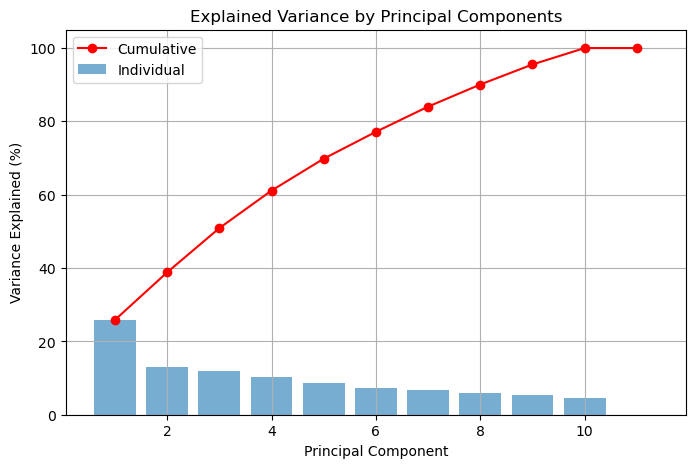

<Figure size 640x480 with 0 Axes>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

# load the data
clr_sham_normalised_df = pd.read_csv("./data/outputs/microbiome/simplified_microbiome_clr_sham_normalised.csv")
# abundance_columns = [col for col in clr_sham_normalised_df.columns if col not in ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']]
abundance_columns = [col for col in abundance_columns if col not in ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'PIG8']] #To remove the PIG8 column if necessary

# Perform PCA on the Z-score matrix
pca = PCA()
pca.fit(clr_sham_normalised_df[abundance_columns].T)  # Transpose so samples are rows

# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage
cumulative_variance = np.cumsum(explained_variance)  # Cumulative sum
print(f"cumulative_variance: {cumulative_variance}")

# Plot explained variance
plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label="Individual")
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='r', label="Cumulative")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.title("Explained Variance by Principal Components")
plt.legend()
plt.grid()
plt.show()
plt.savefig("./data/outputs/microbiome/pca_explained_variance.png")


There seems to be maybe be something here. Let's move to a 2D plot

### 2D plot

In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# Load CLR-normalized dataset (excluding PIG8)
clr_sham_normalised_df = pd.read_csv("./data/outputs/microbiome/simplified_microbiome_clr_sham_normalised.csv")

# Define abundance columns excluding taxonomy metadata and PIG8
abundance_columns = [col for col in clr_sham_normalised_df.columns if col not in ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'PIG8']]

# Perform PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(clr_sham_normalised_df[abundance_columns].T)  # Transpose so samples are rows

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'], index=abundance_columns)

# Add sample groups for visualization (Sham: PIG1-4, Treatment: PIG5-12)
pca_df['Group'] = ['Sham' if 'PIG' in sample and int(sample.replace("PIG", "")) <= 4 else 'Treatment' for sample in abundance_columns]

# Create interactive 2D PCA scatter plot (PC1 vs PC2)
fig = px.scatter(
    pca_df, x='PC1', y='PC2', color='Group', text=pca_df.index,
    title="PCA of CLR Normalized Microbiome Data (Relative to Sham)",
    labels={'PC1': f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)",
            'PC2': f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)"},
    template="plotly_white"
)

fig.update_traces(textposition='top center')
fig.show()
fig.write_html("./data/outputs/microbiome/pca2d_clr_sham_normalized.html")

#Plot in 3d
fig = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Group',
    title="PCA of Microbiome Data (PC1 vs. PC2 vs. PC3)",
    labels={'PC1': f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)",
            'PC2': f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)",
            'PC3': f"PC3 ({pca.explained_variance_ratio_[2]*100:.2f}% Variance)"},
    template="plotly_white"
)

fig.show()

fig.write_html("./data/outputs/microbiome/PCA_3D_plotly.html")

### PCA Loadings

In [31]:
# Get microbial taxa names (excluding metadata columns)
microbial_taxa = clr_sham_normalized_df.iloc[:, :6].apply(lambda x: ";".join(x), axis=1)

loadings = pd.DataFrame(
    pca.components_.T,  # Transpose so rows correspond to microbes
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=microbial_taxa  # Set correct microbial taxa as index
)

# Compute absolute contributions to PC1 and PC2
loadings['PC1_abs'] = loadings['PC1'].abs()
loadings['PC2_abs'] = loadings['PC2'].abs()

# Identify top contributing microbes for PC1 and PC2
top_PC1_contributors = loadings.nlargest(25, 'PC1_abs')[['PC1']]
top_PC2_contributors = loadings.nlargest(25, 'PC2_abs')[['PC2']]

# Merge results into a single DataFrame
top_loadings_df = pd.concat([top_PC1_contributors, top_PC2_contributors], axis=1)

top_loadings_df.to_csv("./data/outputs/microbiome/top_loadings.csv", index=True)
top_loadings_df

,PC1,PC2
Bacteria;Firmicutes;Clostridia;Clostridiales;Ruminococcaceae;Oscillospira,0.211003,NaN
Bacteria;Firmicutes;Clostridia;Clostridiales;Clostridiaceae_1;Sarcina,0.194436,NaN
Bacteria;Firmicutes;Erysipelotrichia;Erysipelotrichales;Erysipelotrichaceae;Sharpea,-0.194029,NaN
Bacteria;Actinobacteria;Actinobacteria;Bifidobacteriales;Bifidobacteriaceae;Bifidobacterium,-0.190686,NaN
Bacteria;Actinobacteria;Coriobacteriia;Coriobacteriales;Atopobiaceae;Olsenella,-0.170681,NaN
Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae;Lachnospiraceae_AC2044_group,-0.170084,NaN
Bacteria;Proteobacteria;Gammaproteobacteria;Betaproteobacteriales;Burkholderiaceae;Oxalobacter,0.169585,NaN
Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae;Lachnospiraceae_NK4A136_group,0.169173,NaN
Bacteria;Firmicutes;Negativicutes;Selenomonadales;Veillonellaceae;Dialister,-0.155942,0.121432
Bacteria;Firmicutes;Clostridia;Clostridiales;Peptostreptococcaceae;Terrisporobacter,-0.155231,0.134979


Unsurprisingly a lot of Cdiff bacteria contribut to the PCs

## Identify the biggest changes

In [ ]:
# Create a unified taxonomy identifier using a semicolon separator
test = clr_sham_normalised_df.copy()

test["Taxa_ID"] = test[['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']].agg(';'.join, axis=1)
test.set_index("Taxa_ID", inplace=True)

# Identify top contributing microorganisms from PCA loadings
top_microbes_PC1 = loadings["PC1"].abs().nlargest(25).index.tolist()
top_microbes_PC2 = loadings["PC2"].abs().nlargest(25).index.tolist()

# Extract these from the CLR-normalized dataset
top_microbes = list(set(top_microbes_PC1 + top_microbes_PC2))
top_microbes_df = test.loc[top_microbes]

# Define sample groups
sham_samples = ["PIG1", "PIG2", "PIG3", "PIG4"]
treatment_one = ["PIG5", "PIG6", "PIG7", "PIG8"]
treatment_two = ["PIG9", "PIG10", "PIG11", "PIG12"]

# Compute the mean CLR values across Sham and Treatment
top_microbes_df["Sham_Mean"] = top_microbes_df[sham_samples].mean(axis=1)
top_microbes_df["Treatment_One"] = top_microbes_df[treatment_one].mean(axis=1)
top_microbes_df["Treatment_Two"] = top_microbes_df[treatment_two].mean(axis=1)

# Determine Upregulated vs. Downregulated Microbes
top_microbes_df["Regulation_One"] = ["Upregulated" if fc > 0 else "Downregulated" for fc in top_microbes_df["Treatment_One"]]
top_microbes_df["Regulation_Two"] = ["Upregulated" if fc > 0 else "Downregulated" for fc in top_microbes_df["Treatment_Two"]]
top_microbes_df.to_csv("./data/outputs/microbiome/top_microbes.csv", index=True)

display(test)
display(top_microbes_df)

,Kingdom,Phylum,Class,Order,Family,Genus,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
Taxa_ID,,,,,,,,,,,,,,,,,,
Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanobrevibacter,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,5.712125,-12.822773,3.214027,3.896622,-12.485928,-11.985055,1.950571,-7.293887,0.393945,2.563876,-0.498228,2.168895
Archaea;Euryarchaeota;Methanobacteria;Methanobacteriales;Methanobacteriaceae;Methanosphaera,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanosphaera,-12.785886,2.986584,4.314428,5.484874,5.765457,7.508467,6.165398,10.453738,5.349650,6.316346,2.914325,6.519345
Bacteria;Actinobacteria;Actinobacteria;Actinomycetales;Actinomycetaceae;Actinomyces,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,-2.980137,-2.566300,8.441374,-2.894937,-2.229455,-1.728582,10.597607,2.962586,11.033410,-1.492345,-3.370694,9.940467
Bacteria;Actinobacteria;Actinobacteria;Bifidobacteriales;Bifidobacteriaceae;Aeriscardovia,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Aeriscardovia,0.119737,0.533575,-0.858250,0.204938,0.870419,1.371293,0.342435,6.062461,0.183570,1.607530,13.656626,1.041698
Bacteria;Actinobacteria;Actinobacteria;Bifidobacteriales;Bifidobacteriaceae;Bifidobacterium,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,-5.910264,6.958044,4.777283,-5.825063,-5.159582,8.189294,11.864430,0.032460,10.452057,13.610988,10.762118,12.466795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bacteria;Proteobacteria;Gammaproteobacteria;Pasteurellales;Pasteurellaceae;Aggregatibacter,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Aggregatibacter,-3.097638,-2.683800,8.793875,-3.012437,-2.346956,-1.846082,-2.874940,2.845086,11.002920,-1.609846,-3.488195,-2.175677
Bacteria;Spirochaetes;Spirochaetia;Spirochaetales;Spirochaetaceae;Treponema_2,Bacteria,Spirochaetes,Spirochaetia,Spirochaetales,Spirochaetaceae,Treponema_2,2.377280,-0.653226,-0.646288,-1.077766,-3.470702,-3.040061,-2.606373,-9.548248,-3.364490,-0.675768,-0.614706,0.630565
Bacteria;Tenericutes;Mollicutes;Anaeroplasmatales;Anaeroplasmataceae;Anaeroplasma,Bacteria,Tenericutes,Mollicutes,Anaeroplasmatales,Anaeroplasmataceae,Anaeroplasma,-3.167167,10.394287,-4.145154,-3.081966,-2.416485,-1.915611,-2.944469,2.775557,-3.103334,-1.679374,9.165752,-2.245206


,Kingdom,Phylum,Class,Order,Family,Genus,PIG1,PIG2,PIG3,PIG4,...,PIG8,PIG9,PIG10,PIG11,PIG12,Sham_Mean,Treatment_One,Treatment_Two,Regulation_One,Regulation_Two
Taxa_ID,,,,,,,,,,,,,,,,,,,,,
Bacteria;Firmicutes;Negativicutes;Selenomonadales;Veillonellaceae;Mitsuokella,Bacteria,Firmicutes,Negativicutes,Selenomonadales,Veillonellaceae,Mitsuokella,-1.647456,0.878156,-0.630633,1.399934,...,-9.465152,-2.325886,-13.920083,-3.192740,-0.995621,3.885781e-16,-9.529789,-5.108583,Downregulated,Downregulated
Bacteria;Firmicutes;Negativicutes;Selenomonadales;Veillonellaceae;Anaerovibrio,Bacteria,Firmicutes,Negativicutes,Selenomonadales,Veillonellaceae,Anaerovibrio,-0.762015,-0.574935,0.645495,0.691455,...,-8.947436,-14.826327,-13.402367,-0.711417,-0.583265,8.881784e-16,-5.679875,-7.380844,Downregulated,Downregulated
Bacteria;Proteobacteria;Gammaproteobacteria;Pasteurellales;Pasteurellaceae;Actinobacillus,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Actinobacillus,0.119737,0.533575,-0.858250,0.204938,...,6.062461,0.183570,1.607530,-0.270820,1.041698,-4.510281e-16,8.947817,0.640495,Upregulated,Upregulated
Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Prevotellaceae;Prevotellaceae_UCG-001,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotellaceae_UCG-001,-10.279841,3.504755,1.834815,4.940271,...,-4.337118,6.588083,-8.792049,-10.670398,-9.357880,2.220446e-16,-8.237926,-5.558061,Downregulated,Downregulated
Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae;Lachnospiraceae_NK4B4_group,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae_NK4B4_group,4.040733,5.751309,1.596462,-11.388504,...,-5.530981,1.751386,-9.985912,4.260408,-10.551744,4.440892e-16,-5.730714,-3.631465,Downregulated,Downregulated
Bacteria;Firmicutes;Clostridia;Clostridiales;Ruminococcaceae;Ruminococcaceae_UCG-003,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Ruminococcaceae_UCG-003,-6.670436,-6.256598,5.731902,7.195132,...,-0.727712,5.926048,-5.182643,6.930992,7.790609,0.000000e+00,4.772307,3.866251,Upregulated,Upregulated
Bacteria;Elusimicrobia;Elusimicrobia;Elusimicrobiales;Elusimicrobiaceae;Elusimicrobium,Bacteria,Elusimicrobia,Elusimicrobia,Elusimicrobiales,Elusimicrobiaceae,Elusimicrobium,4.602092,3.881829,2.668646,-11.152567,...,-5.295044,-11.173935,-9.749976,-11.628325,-10.315807,-4.440892e-16,-2.883968,-10.717011,Downregulated,Downregulated
Bacteria;Actinobacteria;Actinobacteria;Corynebacteriales;Corynebacteriaceae;Corynebacterium_1,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Corynebacteriaceae,Corynebacterium_1,0.119737,0.533575,-0.858250,0.204938,...,6.062461,0.183570,14.493110,-0.270820,1.041698,-4.510281e-16,9.206334,3.861890,Upregulated,Upregulated
Bacteria;Firmicutes;Bacilli;Lactobacillales;Aerococcaceae;Aerococcus,Bacteria,Firmicutes,Bacilli,Lactobacillales,Aerococcaceae,Aerococcus,10.070695,-2.783411,-4.175236,-3.112048,...,2.745475,-3.133416,-1.709456,-3.587806,-2.275288,4.440892e-16,1.663570,-2.676491,Upregulated,Downregulated


In [49]:
grouped_top_microbes_df = top_microbes_df.groupby(["Phylum","Class"])[["PIG1", "PIG2", "PIG3", "PIG4", "PIG5", "PIG6", "PIG7", "PIG8", "PIG9", "PIG10", "PIG11", "PIG12", "Sham_Mean", "Treatment_One", "Treatment_Two"]].mean()
grouped_top_microbes_df["Regulation_One"] = ["Upregulated" if fc > 0 else "Downregulated" for fc in grouped_top_microbes_df["Treatment_One"]]
grouped_top_microbes_df["Regulation_Two"] = ["Upregulated" if fc > 0 else "Downregulated" for fc in grouped_top_microbes_df["Treatment_Two"]]
grouped_top_microbes_df.to_csv("./data/outputs/microbiome/grouped_top_microbes.csv", index=True)
display(grouped_top_microbes_df)

PIG1       PIG2      PIG3  \
Phylum             Class                                                 
Actinobacteria     Actinobacteria       -1.086263   1.818469  0.268856   
                   Coriobacteriia        0.119737   0.533575 -0.858250   
Bacteroidetes      Bacteroidia          -2.779360   1.471127  0.363319   
Elusimicrobia      Elusimicrobia         4.602092   3.881829  2.668646   
Epsilonbacteraeota Campylobacteria       4.867916  -1.049151 -2.440976   
Firmicutes         Bacilli              10.070695  -2.783411 -4.175236   
                   Clostridia           -1.017599   0.864942  0.771655   
                   Erysipelotrichia     -3.446667  -3.032830  3.094621   
                   Negativicutes        -0.660166   0.049972 -3.983182   
Planctomycetes     Planctomycetacia      5.878073 -11.673201  3.323453   
Proteobacteria     Gammaproteobacteria   3.797118  -1.000300 -1.566641   

                                             PIG4       PIG5       PIG6  \
Phylum             Class                                                  
Actinobacteria     Actinobacteria       -1.001062  -0.335581  14.242669   
                   Coriobacteriia        0.204938   0.870419   1.371293   
Bacteroidetes      Bacteroidia           0.944913  -2.881539  -7.886789   
Elusimicrobia      Elusimicrobia       -11.152567 -10.487086   3.292572   
Epsilonbacteraeota Campylobacteria      -1.377788  -0.712307  15.581649   
Firmicutes         Bacilli              -3.112048  -2.446566  -1.945693   
                   Clostridia           -0.618998  -1.353447  -4.892269   
                   Erysipelotrichia      3.384876  -2.695985  -2.195112   
                   Negativicutes         4.593377  -3.280514  -5.857531   
Planctomycetes     Planctomycetacia      2.471675 -11.336356 -10.835483   
Proteobacteria     Gammaproteobacteria  -1.230177   0.033319   4.718117   

                                             PIG7      PIG8       PIG9  \
Phylum             Class                                                 
Actinobacteria     Actinobacteria       14.413621  4.856461   2.237267   
                   Coriobacteriia        4.136094  6.062461   4.913862   
Bacteroidetes      Bacteroidia         -12.783918 -7.063893   0.821894   
Elusimicrobia      Elusimicrobia         0.953687 -5.295044 -11.173935   
Epsilonbacteraeota Campylobacteria      11.304806  4.479735   4.579489   
Firmicutes         Bacilli               8.301066  2.745475  -3.133416   
                   Clostridia           -4.977773 -2.336192  -0.019683   
                   Erysipelotrichia      3.911699  2.496056  11.940091   
                   Negativicutes        -7.622959 -5.129689  -4.312192   
Planctomycetes     Planctomycetacia      2.096841 -6.144315 -12.023206   
Proteobacteria     Gammaproteobacteria   4.171825  0.190558  -0.667212   

                                            PIG10      PIG11      PIG12  \
Phylum             Class                                                  
Actinobacteria     Actinobacteria        6.585337   1.935768   3.326718   
                   Coriobacteriia        7.344345   9.571302  17.292888   
Bacteroidetes      Bacteroidia         -11.518824  -4.508023  -8.145881   
Elusimicrobia      Elusimicrobia        -9.749976 -11.628325 -10.315807   
Epsilonbacteraeota Campylobacteria       0.024803  12.201221   8.077398   
Firmicutes         Bacilli              -1.709456  -3.587806  -2.275288   
                   Clostridia           -2.925962  -0.500332  -2.968118   
                   Erysipelotrichia      6.036954  11.747678  13.034289   
                   Negativicutes        -5.908436  -0.992147   0.878010   
Planctomycetes     Planctomycetacia      2.797159 -12.477595 -11.165078   
Proteobacteria     Gammaproteobacteria   1.139564  -1.574622  -4.830205   

                                           Sham_Mean  Treatment_One  \
Phylum             Class                                              
Actinobacteria     Actino

### Group by Phylum and Class
Ok so that is for the top microbes from the PCA analysis. Let's see what happens if we look at the data as a whole

In [51]:
import pandas as pd

# Start by loading the data
simplified_microbiome_clr_sham_normalised_df = pd.read_csv("./data/outputs/microbiome/simplified_microbiome_clr_sham_normalised.csv")
temp = simplified_microbiome_clr_sham_normalised_df.copy()

# Define the abundance columns
abundance_columns = [col for col in simplified_microbiome_clr_sham_normalised_df.columns if col not in ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']]
# Define the metadata columns (Taxa)
taxa_columns = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
# Define the taxa identifier and place as index
temp["Taxa_ID"] = simplified_microbiome_clr_sham_normalised_df[taxa_columns].agg(';'.join, axis=1)
temp.set_index("Taxa_ID", inplace=True)

# Define the sample groups
sham_samples = ["PIG1", "PIG2", "PIG3", "PIG4"]
treatment_one = ["PIG5", "PIG6", "PIG7", "PIG8"]
treatment_two = ["PIG9", "PIG10", "PIG11", "PIG12"]

# Group by Phylum and Class and compute the mean CLR values across Sham and Treatments
grouped_microbiome_df = temp.groupby(["Phylum", "Class"])[abundance_columns].mean()
grouped_microbiome_df["Sham_Mean"] = grouped_microbiome_df[sham_samples].mean(axis=1)
grouped_microbiome_df["Treatment_One"] = grouped_microbiome_df[treatment_one].mean(axis=1)
grouped_microbiome_df["Treatment_Two"] = grouped_microbiome_df[treatment_two].mean(axis=1)

# Determine Upregulated vs. Downregulated Microbes
grouped_microbiome_df["Regulation_One"] = ["Upregulated" if fc > 0 else "Downregulated" for fc in grouped_microbiome_df["Treatment_One"]]
grouped_microbiome_df["Regulation_Two"] = ["Upregulated" if fc > 0 else "Downregulated" for fc in grouped_microbiome_df["Treatment_Two"]]
grouped_microbiome_df.to_csv("./data/outputs/microbiome/grouped_microbiome.csv", index=True)
display(grouped_microbiome_df)

# # Compute the mean CLR values across Sham and Treatments
# temp["Sham_Mean"] = temp[sham_samples].mean(axis=1)
# temp["Treatment_One"] = temp[treatment_one].mean(axis=1)
# temp["Treatment_Two"] = temp[treatment_two].mean(axis=1)

# # Determine Upregulated vs. Downregulated Microbes
# temp["Regulation_One"] = ["Upregulated" if fc > 0 else "Downregulated" for fc in temp["Treatment_One"]]
# temp["Regulation_Two"] = ["Upregulated" if fc > 0 else "Downregulated" for fc in temp["Treatment_Two"]]

PIG1       PIG2      PIG3  \
Phylum              Class                                                
Actinobacteria      Actinobacteria      -0.980449   0.565613  1.310083   
                    Coriobacteriia      -0.145997   0.544154 -0.781225   
Bacteroidetes       Bacteroidia          0.674513   0.067994 -1.099453   
Deferribacteres     Deferribacteres      0.119737   0.533575 -0.858250   
Deinococcus-Thermus Deinococci           0.119737   0.533575 -0.858250   
Elusimicrobia       Elusimicrobia        4.602092   3.881829  2.668646   
Epsilonbacteraeota  Campylobacteria      4.867916  -1.049151 -2.440976   
Euryarchaeota       Methanobacteria     -3.536881  -4.918095  3.764227   
Fibrobacteres       Fibrobacteria        6.361580  -6.174073  6.315202   
Firmicutes          Bacilli              1.439858   0.373245 -1.610233   
                    Clostridia          -0.279132   0.146150  0.105086   
                    Erysipelotrichia    -0.525648   0.078407  0.189789   
                    Negativicutes       -1.734824   0.583431 -1.821251   
Fusobacteria        Fusobacteriia        0.119737   0.533575 -0.858250   
Parabasalia         Trichomonadea        0.119737   0.533575 -0.858250   
Patescibacteria     Saccharimonadia      0.119737   0.533575 -0.858250   
Planctomycetes      Planctomycetacia     5.878073 -11.673201  3.323453   
Proteobacteria      Deltaproteobacteria  0.213304  -0.807810  0.132115   
                    Gammaproteobacteria  3.149549  -2.415356  1.967474   
Spirochaetes        Spirochaetia         2.377280  -0.653226 -0.646288   
Tenericutes         Mollicutes          -3.167167  10.394287 -4.145154   
Verrucomicrobia     Verrucomicrobiae     0.119737   0.533575 -0.858250   

                                              PIG4       PIG5       PIG6  \
Phylum              Class                                                  
Actinobacteria      Actinobacteria       -0.895248  -0.229766   6.669915   
                    Coriobacteriia        0.383068   1.321448   1.680286   
Bacteroidetes       Bacteroidia           0.356946   0.813688  -1.781533   
Deferribacteres     Deferribacteres       0.204938   0.870419   1.371293   
Deinococcus-Thermus Deinococci            0.204938   0.870419   1.371293   
Elusimicrobia       Elusimicrobia       -11.152567 -10.487086   3.292572   
Epsilonbacteraeota  Campylobacteria      -1.377788  -0.712307  15.581649   
Euryarchaeota       Methanobacteria       4.690748  -3.360236  -2.238294   
Fibrobacteres       Fibrobacteria        -6.502710  -5.837228  -5.336355   
Firmicutes          Bacilli              -0.202871  -1.531822  -0.045063   
                    Clostridia            0.027896  -0.124786  -1.220095   
                    Erysipelotrichia      0.257452  -0.740327   2.799657   
                    Negativicutes         2.972643   0.690012  -3.863230   
Fusobacteria        Fusobacteriia         0.204938  13.084461   1.371293   
Parabasalia         Trichomonadea         0.204938   0.870419  14.873221   
Patescibacteria     Saccharimonadia       0.204938  13.372142  14.650077   
Planctomycetes      Planctomycetacia      2.471675 -11.336356 -10.835483   
Proteobacteria      Deltaproteobacteria   0.462391   0.607755   0.442059   
                    Gammaproteobacteria  -2.701667   0.117889   2.213018   
Spirochaetes        Spirochaetia         -1.077766  -3.470702  -3.040061   
Tenericutes         Mollicutes           -3.081966  -2.416485  -1.915611   
Verrucomicrobia     Verrucomicrobiae      0.204938  11.580401   1.371293   

                                              PIG7      PIG8       PIG9  \
Phylum              Class                                                 
Actinobacteria      Actinobacteria       12.146142  4.962275   4.096439   
                    Coriobacteriia        2.901411  6.725377   3.115445   
Bacteroidetes       Bacteroidia          -5.041806 -3.897770  -0.131367   
Deferribacteres     Deferribacteres      12.311192  6.062461   0.183

In [70]:
grouped_microbiome_df.max()

PIG1                  6.36158
PIG2                10.394287
PIG3                 6.315202
PIG4                 4.690748
PIG5                13.372142
PIG6                15.581649
PIG7                14.045788
PIG8                 6.725377
PIG9                12.023077
PIG10               19.375909
PIG11               12.201221
PIG12                14.33962
Sham_Mean                 0.0
Treatment_One        8.606779
Treatment_Two        8.042466
Regulation_One    Upregulated
Regulation_Two    Upregulated
dtype: object

In [72]:
#Plot heatmaps for the grouped data
import plotly.express as px
import pandas as pd

# Create a heatmap for the grouped data
heatmap_df = grouped_microbiome_df.copy()

#Aggregate the phylum class names to a single axis
heatmap_df.index = heatmap_df.index.map(lambda x: f"{x[0]} - {x[1]}")  # Convert tuple index to string

heatmap_df = heatmap_df.drop(columns=["Sham_Mean", "Treatment_One", "Treatment_Two", "Regulation_One", "Regulation_Two"])

# Create an interactive heatmap
fig = px.imshow(
    heatmap_df, 
    labels=dict(x="Samples", y="Taxa", color="Mean Log Normalised TSS counts"),
    color_continuous_scale="RdBu_r",  # Blue = low, Red = high expression
    zmin=-20, zmax=20,  # Adjust this range if needed for better visualization
    aspect="auto"
)
fig.show()
display(heatmap_df)
fig.write_html("./data/outputs/microbiome/grouped_microbiome_heatmap.html")


,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
Actinobacteria - Actinobacteria,-0.980449,0.565613,1.310083,-0.895248,-0.229766,6.669915,12.146142,4.962275,4.096439,3.318165,1.446302,2.619125
Actinobacteria - Coriobacteriia,-0.145997,0.544154,-0.781225,0.383068,1.321448,1.680286,2.901411,6.725377,3.115445,5.105210,5.000226,9.453278
Bacteroidetes - Bacteroidia,0.674513,0.067994,-1.099453,0.356946,0.813688,-1.781533,-5.041806,-3.897770,-0.131367,-1.121029,-2.664554,-1.005930
Deferribacteres - Deferribacteres,0.119737,0.533575,-0.858250,0.204938,0.870419,1.371293,12.311192,6.062461,0.183570,1.607530,-0.270820,14.339620
Deinococcus-Thermus - Deinococci,0.119737,0.533575,-0.858250,0.204938,0.870419,1.371293,14.045788,6.062461,0.183570,1.607530,-0.270820,1.041698
Elusimicrobia - Elusimicrobia,4.602092,3.881829,2.668646,-11.152567,-10.487086,3.292572,0.953687,-5.295044,-11.173935,-9.749976,-11.628325,-10.315807
Epsilonbacteraeota - Campylobacteria,4.867916,-1.049151,-2.440976,-1.377788,-0.712307,15.581649,11.304806,4.479735,4.579489,0.024803,12.201221,8.077398
Euryarchaeota - Methanobacteria,-3.536881,-4.918095,3.764227,4.690748,-3.360236,-2.238294,4.057984,1.579926,2.871797,4.440111,1.208049,4.344120
Fibrobacteres - Fibrobacteria,6.361580,-6.174073,6.315202,-6.502710,-5.837228,-5.336355,-6.365212,-0.645187,-6.524078,-5.100118,-6.978467,-5.665949
Firmicutes - Bacilli,1.439858,0.373245,-1.610233,-0.202871,-1.531822,-0.045063,5.919104,5.349143,-0.506073,-0.299136,-1.966670,-0.513056


In [126]:
#Lets do box plots for the grouped data
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

grouped_microbiome_df = pd.read_csv("./data/outputs/microbiome/grouped_microbiome.csv")
grouped_microbiome_df

# Define the abundance columns
abundance_columns = [col for col in grouped_microbiome_df.columns if col not in ['Phylum', 'Class', 'Sham_Mean', 'Treatment_One', 'Treatment_Two', 'Regulation_One', 'Regulation_Two']]

# Specify treatments
sham_samples = ["PIG1", "PIG2", "PIG3", "PIG4"]
treatment_one = ["PIG5", "PIG6", "PIG7", "PIG8"]
treatment_two = ["PIG9", "PIG10", "PIG11", "PIG12"]

# Melt
melted_df = grouped_microbiome_df.melt(id_vars=['Phylum', 'Class'], value_vars=abundance_columns, var_name="Sample", value_name="Abundance")
#Assign the treatment group
melted_df["Group"] = ["Sham" if sample in sham_samples else "Treatment_One" if sample in treatment_one else "Treatment_Two" for sample in melted_df["Sample"]]
melted_df

# Define color mapping for groups
color_map = {"Sham": "blue", "Treatment_One": "orange", "Treatment_Two": "green"}

# Create subplots
fig = make_subplots(rows=2, cols=1, subplot_titles=("CLR values per Phylum", "CLR values per Class"))

# Sort x-axis categories (Ensuring correct order)
phylum_order = sorted(melted_df["Phylum"].unique())
class_order = sorted(melted_df["Class"].unique())

# **Define group offsets to avoid overlap**
offsets = {"Sham": -0.3, "Treatment_One": 0, "Treatment_Two": 0.3}  # Spread out the groups

# **Increase box width**
box_width = 0.2  # Adjust as needed (default is ~0.2)

# Add box plot for Phylum (adjacent groups)
for group in ["Sham", "Treatment_One", "Treatment_Two"]:
    group_data = melted_df[melted_df["Group"] == group]
    fig.add_trace(go.Box(
        y=group_data["Abundance"],
        x=[phylum_order.index(p) + offsets[group] for p in group_data["Phylum"]],  # Adjust x positions
        name=group,
        width=box_width,  # Adjusted width
        boxpoints="all",
        jitter=0.1,  # Spread out points
        marker=dict(color=color_map[group], opacity=0.6),
        showlegend=True,  # Keep legend only in subplot 1
    ), row=1, col=1)

# Add box plot for Class (adjacent groups)
for group in ["Sham", "Treatment_One", "Treatment_Two"]:
    group_data = melted_df[melted_df["Group"] == group]
    fig.add_trace(go.Box(
        y=group_data["Abundance"],
        x=[class_order.index(c) + offsets[group] for c in group_data["Class"]],  # Adjust x positions
        name=group,
        width=box_width,
        boxpoints="all",
        jitter=0.1,
        marker=dict(color=color_map[group], opacity=0.6),
        showlegend=False,
    ), row=2, col=1)

# **Shift tick labels by 0.5 to align with center**
phylum_tickvals = [i-0.25 for i in range(len(phylum_order))]
class_tickvals = [i-0.25 for i in range(len(class_order))]

# Update layout
fig.update_layout(
    title="CLR Normalized Abundances by Phylum and Class",
    height=900, width=2000,
    showlegend=True,
    template="plotly_white",
    boxmode="group",  # Ensures groups are adjacent, not overlapping
    xaxis=dict(
        tickmode="array",
        tickvals=phylum_tickvals,
        ticktext=phylum_order,
        tickangle=45,  # Ensures centered alignment
    ),
    xaxis2=dict(
        tickmode="array",
        tickvals=class_tickvals,
        ticktext=class_order,
        tickangle=45,  # Ensures centered alignment
    ),
)

fig.show()
fig.write_html("./data/outputs/microbiome/grouped_microbiome_boxplot.html")